In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, brier_score_loss, recall_score, precision_score, mean_squared_error, r2_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.frozen import FrozenEstimator
import shap

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6) 
sns.set_theme(rc={'figure.figsize': (10, 6)})
sns.set_style('whitegrid')

In [2]:
#load data
cvd_data = pd.read_csv('data/cardio_data.csv', delimiter=';')

In [3]:
print("=== Dataset Info ===")
cvd_data.info()

print("=== Summary Statistics ===")
display(cvd_data.describe())

print("=== Unique Value Counts ===")
display(cvd_data.nunique())

print("=== Head ===")
display(cvd_data.head())

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
=== Summary Statistics ===


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


=== Unique Value Counts ===


id             70000
age             8076
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

=== Head ===


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
#make a copy of data
cleaned_cvd_data = pd.DataFrame(cvd_data)

cleaned_cvd_data.age = cleaned_cvd_data.age // 365
cleaned_cvd_data.gender = cleaned_cvd_data.gender.replace({1:0, 2:1})

#remove rows with error
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data['ap_hi'] > 0)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data['ap_lo'] > 0)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data['ap_hi'] > cleaned_cvd_data["ap_lo"])]

#create BMI feature
cleaned_cvd_data["height_m"] = cleaned_cvd_data["height"] / 100
cleaned_cvd_data["bmi"] = cleaned_cvd_data["weight"] / (cleaned_cvd_data["height_m"] ** 2)
cleaned_cvd_data.drop(columns=["height_m"], inplace=True)

#create pulse pressure feature
cleaned_cvd_data["pulse_pressure"] = cleaned_cvd_data["ap_hi"] - cleaned_cvd_data["ap_lo"]

In [5]:
display(cleaned_cvd_data.describe())

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse_pressure
count,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000,68742.000000
mean,49975.839312,52.827631,0.348579,164.359693,74.115730,128.776134,81.272250,1.364697,1.225626,0.087879,0.053344,0.803424,0.494821,27.522352,47.503884
std,28843.591732,6.769226,0.476524,8.190790,14.330403,155.061818,9.573336,0.678900,0.571486,0.283121,0.224721,0.397412,0.499977,6.067868,154.585100
min,0.000000,29.000000,0.000000,55.000000,11.000000,16.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.471784,4.000000
25%,25007.250000,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115,40.000000
50%,50019.500000,53.000000,0.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.346494,40.000000
75%,74865.750000,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.119376,50.000000
max,99999.000000,64.000000,1.000000,250.000000,200.000000,16020.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.666667,15940.000000


In [6]:
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
cont_cols = ['age', 'height', 'weight', 'bmi', 'ap_hi', 'ap_lo', 'pulse_pressure']
ordinal_cols = ['cholesterol', 'gluc']
binary_cols = ['gender', 'smoke', 'alco', 'active']

EDA


Text(0.5, 1.0, 'Count by Age Group')

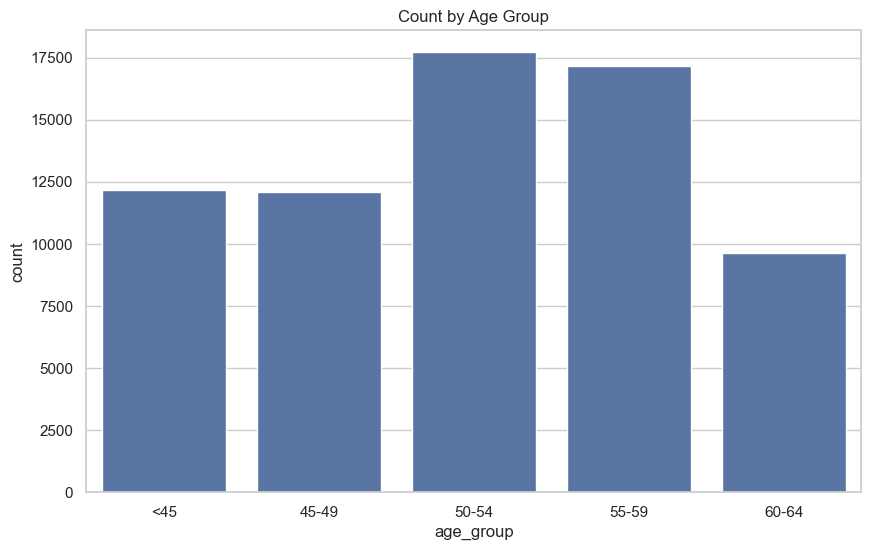

In [7]:
age_group_bin = [0, 45, 50, 55, 60, 65]
age_group_labels = ['<45', '45-49', '50-54', '55-59', '60-64']

cleaned_cvd_data['age_group'] = pd.cut(
    cleaned_cvd_data['age'],
    bins=age_group_bin,
    labels=age_group_labels,
    include_lowest=True
)

sns.countplot(data=cleaned_cvd_data, x='age_group', order=age_group_labels)
plt.title('Count by Age Group')

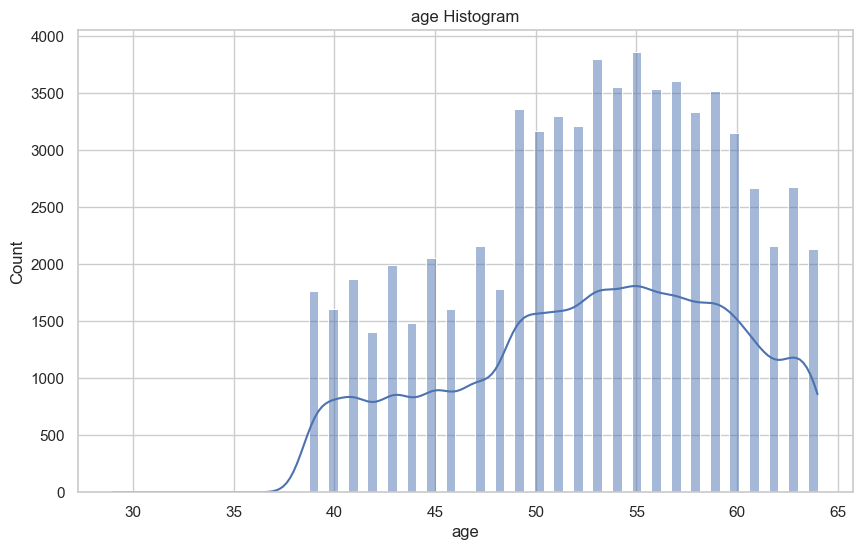

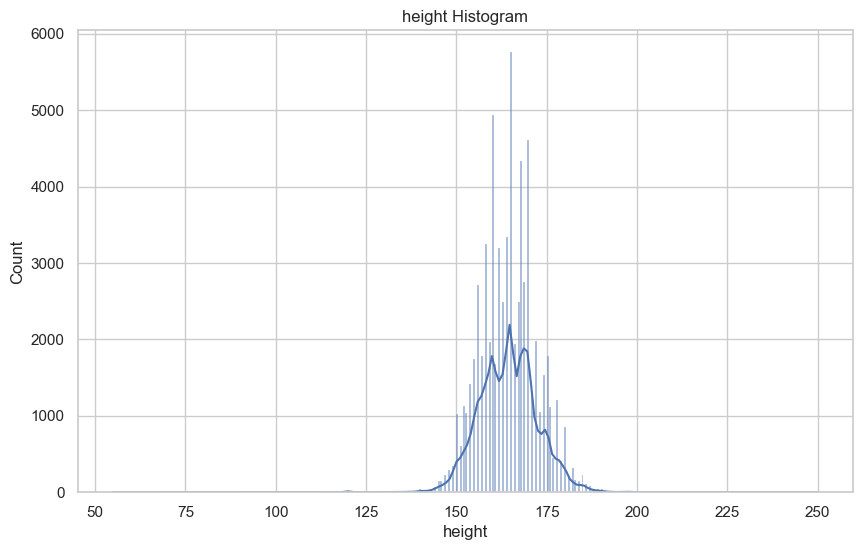

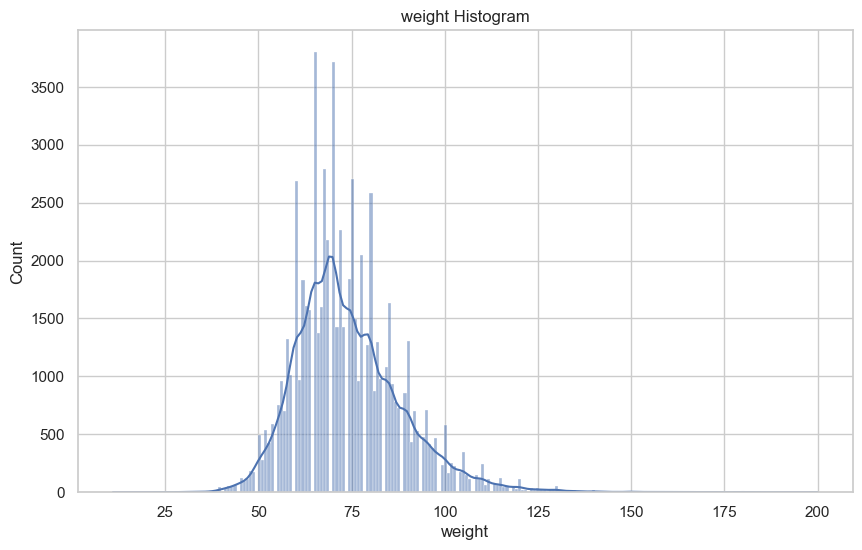

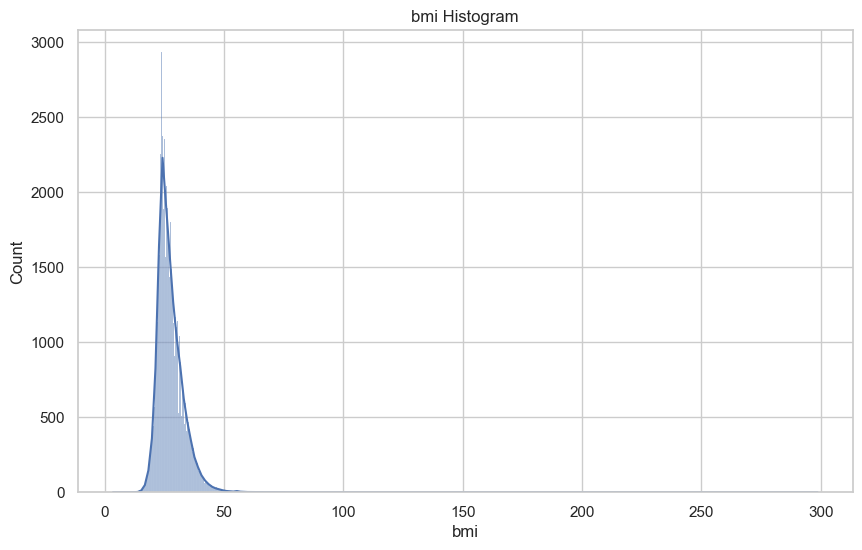

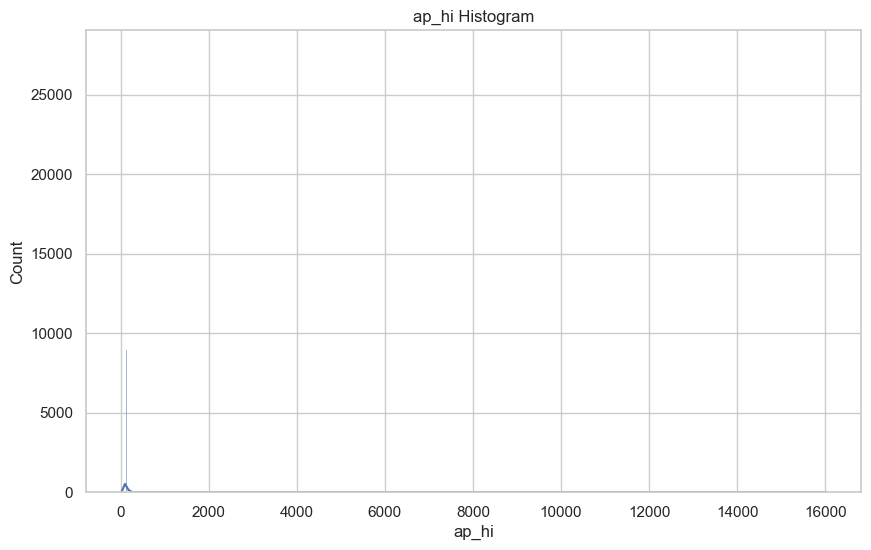

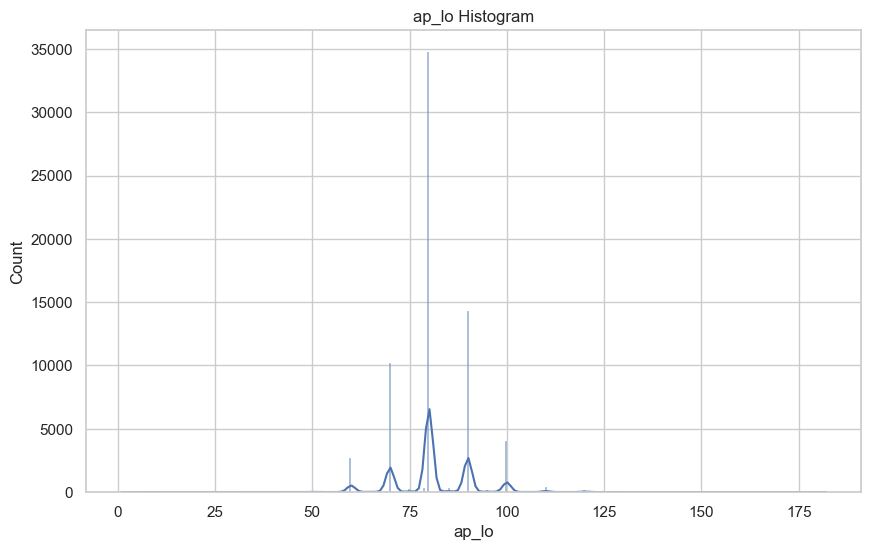

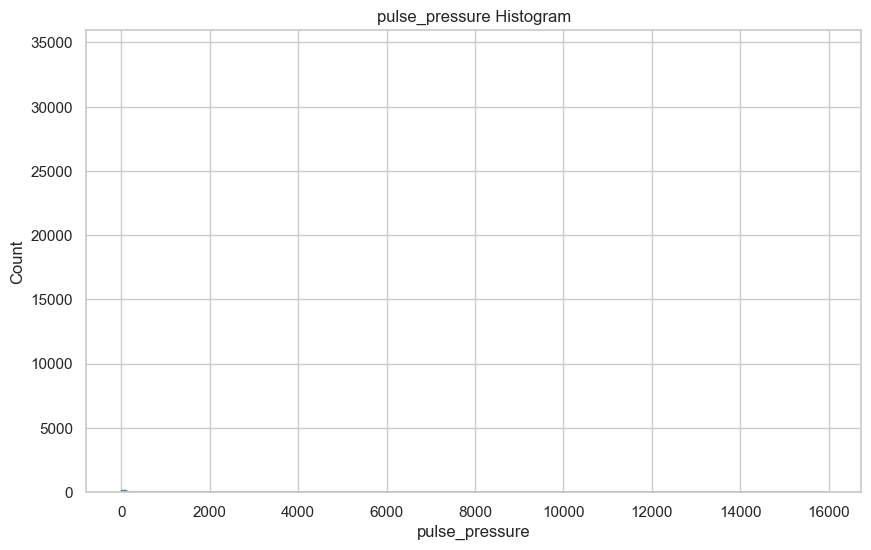

In [8]:
for col in cont_cols:
    sns.histplot(data=cleaned_cvd_data, x = col, kde = True)
    plt.title(f'{col} Histogram')
    plt.show()

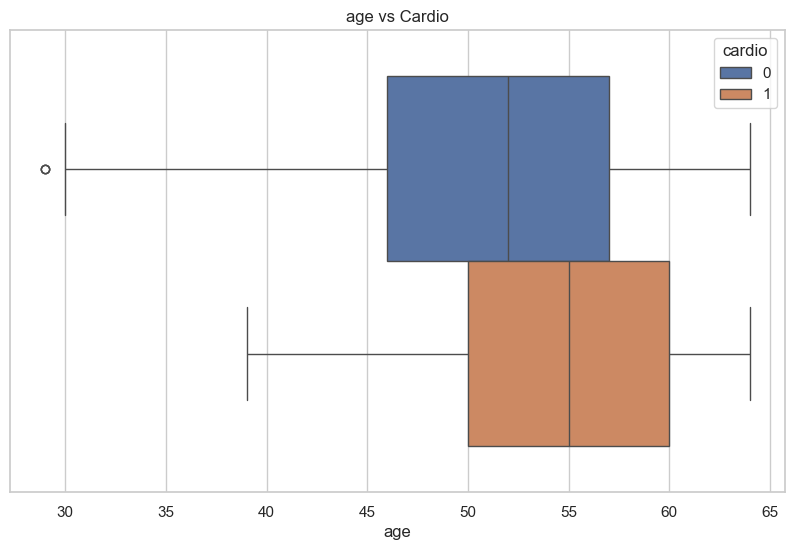

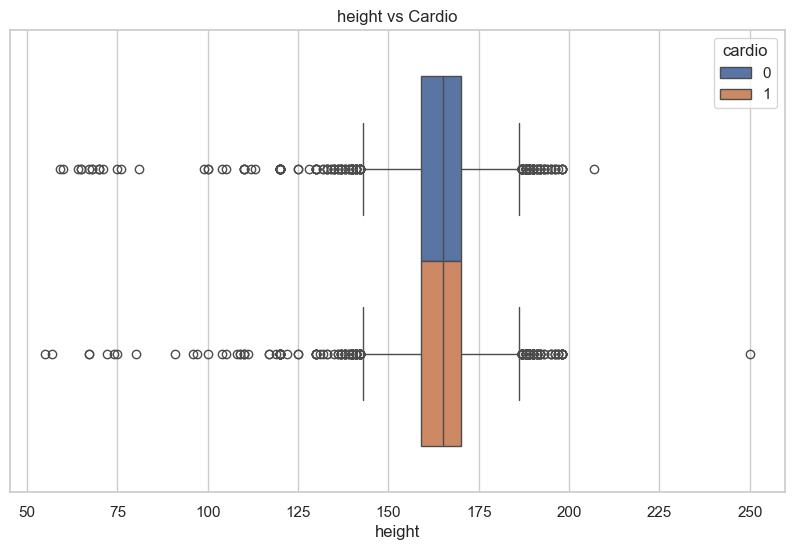

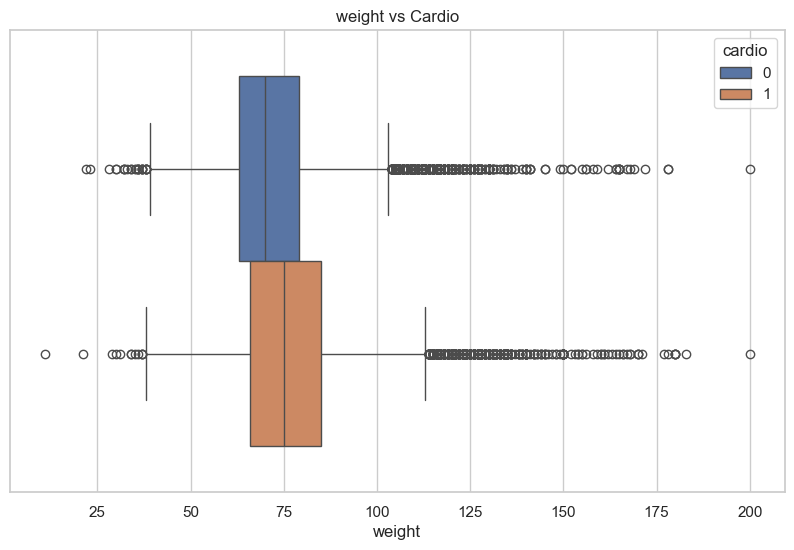

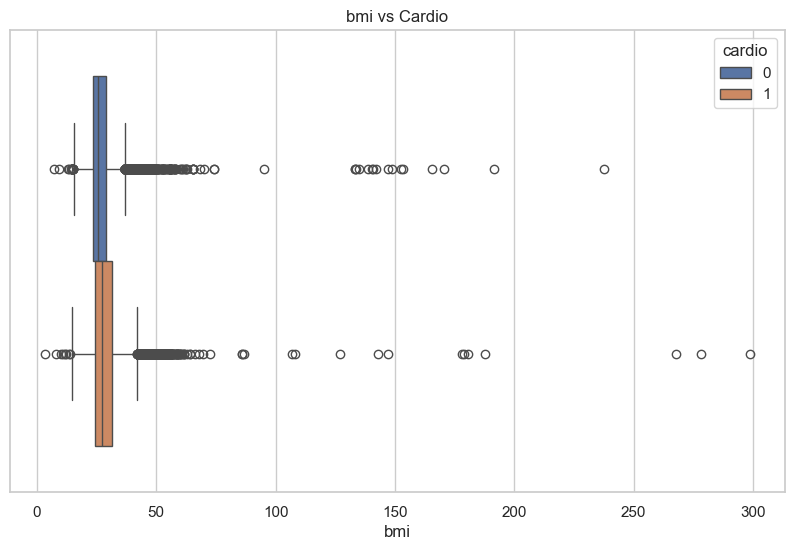

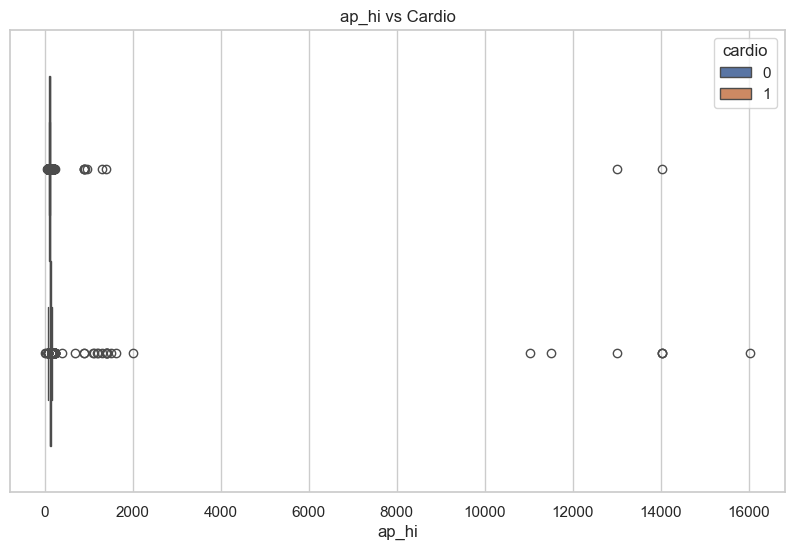

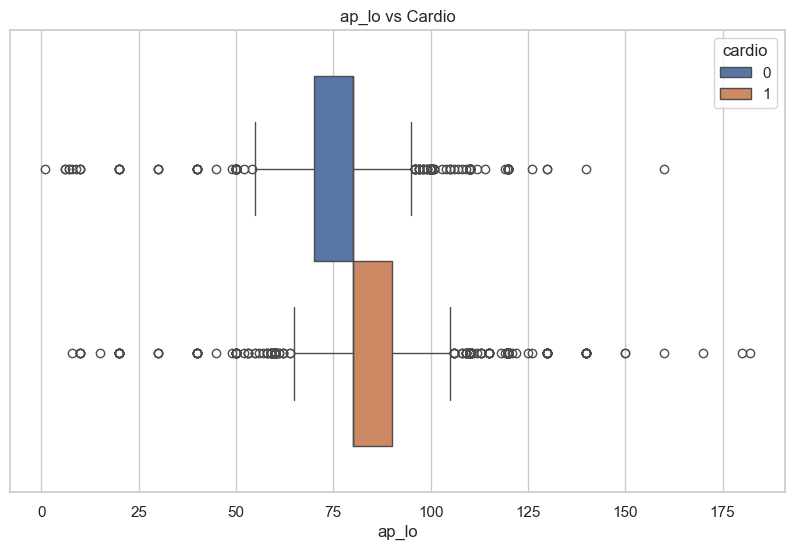

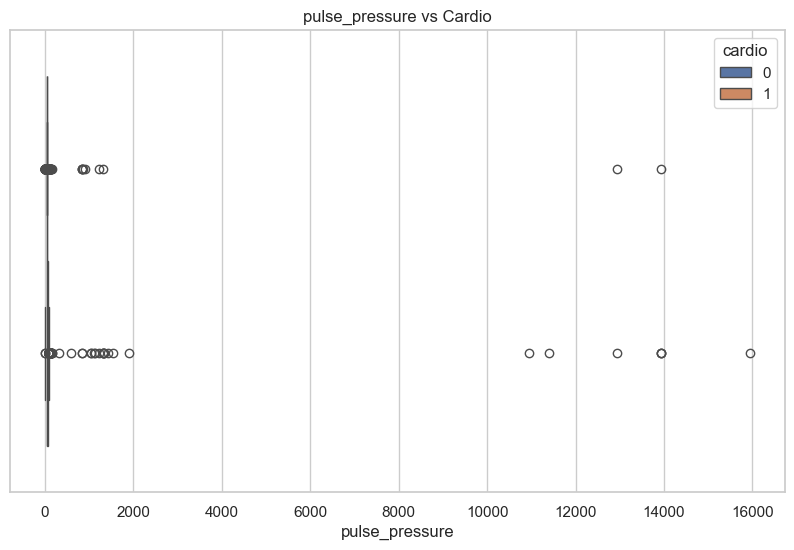

In [9]:
#Boxplot for continuous features
for col in cont_cols:
    sns.boxplot(data = cleaned_cvd_data, x = col, hue = 'cardio')
    plt.title(f"{col} vs Cardio")
    plt.show()

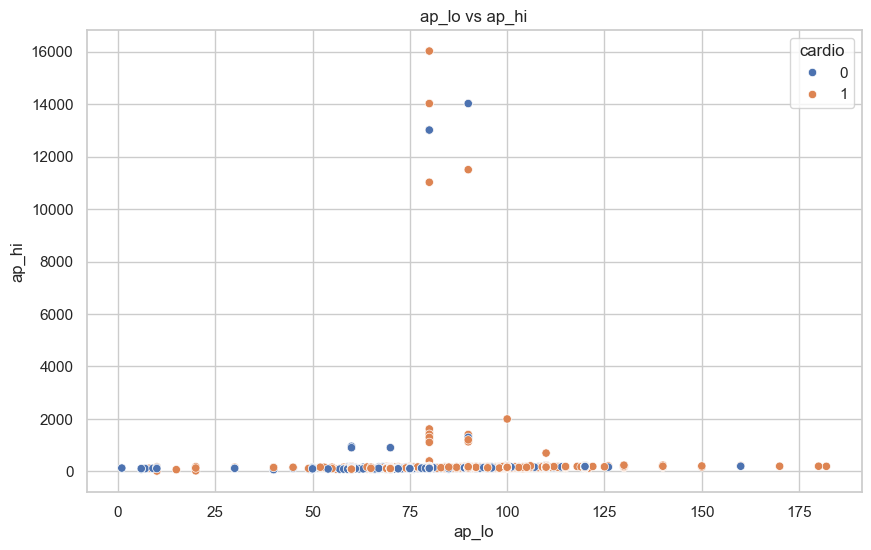

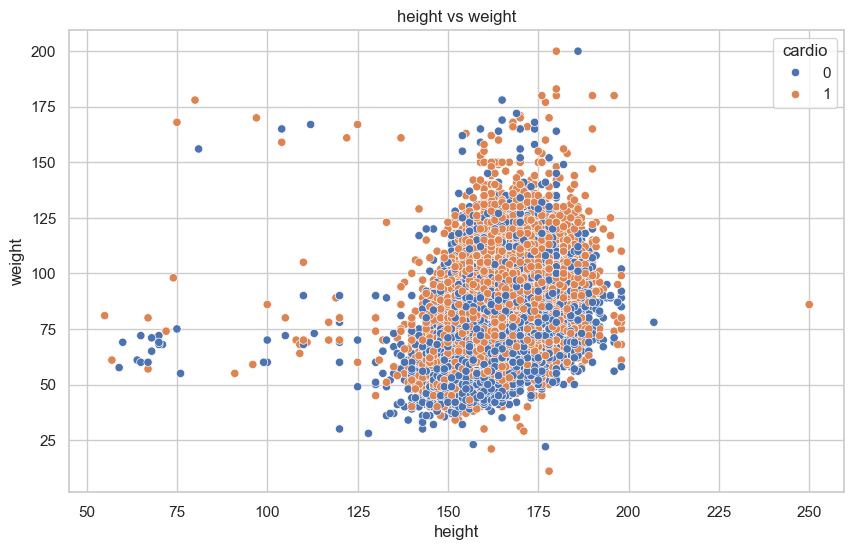

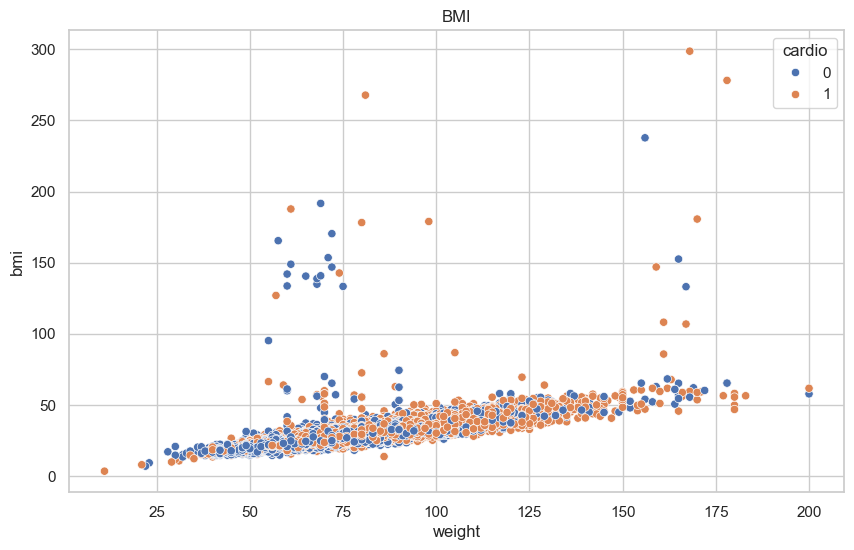

In [10]:
sns.scatterplot(x='ap_lo', y='ap_hi', hue='cardio', data=cleaned_cvd_data)
plt.title('ap_lo vs ap_hi')
plt.show()

sns.scatterplot(x='height', y='weight', hue='cardio', data=cleaned_cvd_data)
plt.title('height vs weight')
plt.show()

sns.scatterplot(x='weight', y='bmi', hue='cardio', data=cleaned_cvd_data)
plt.title('BMI')
plt.show()

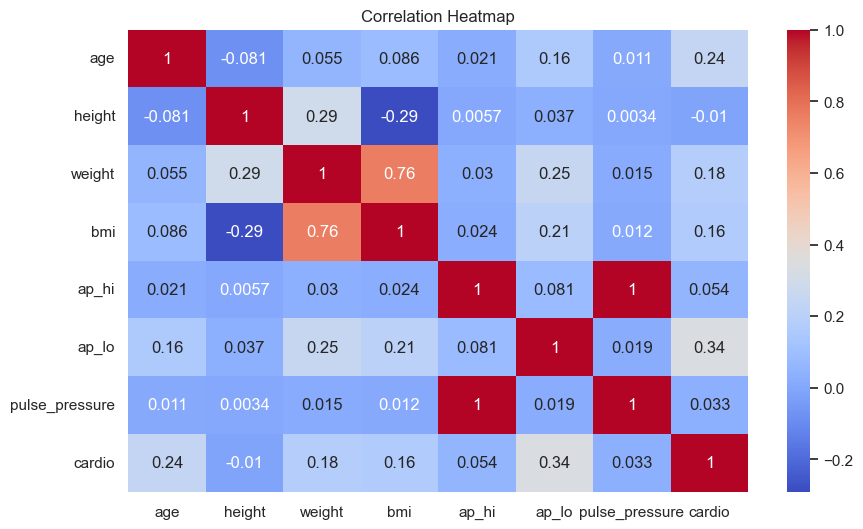

In [11]:
#Correlation Heatmap
cols = [*cont_cols, 'cardio']
sns.heatmap(cleaned_cvd_data[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

**Observation**:
- ap_hi, ap_lo, weight and height has outlier and contains unrealistic data.
- 70 > ap_hi > 240 is not valid,  source: https://www.healthline.com/health/blood-pressure-chart#blood-pressure-charts
- 40 > ap_lo > 200 is not valid, source: https://www.healthline.com/health/blood-pressure-chart#blood-pressure-charts
- 10 > bmi > 60 is not valid, source: https://www.hse.ie/eng/services/list/2/primarycare/east-coast-diabetes-service/management-of-type-2-diabetes/lifestyle-management/healthy-eating-advice/bmi-chart.pdf
- bmi and weight is highly correlated. must drop one of them

In [12]:
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.ap_hi <= 240) & (cleaned_cvd_data.ap_hi >= 70)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.ap_lo <= 160) & (cleaned_cvd_data.ap_lo >= 40)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.pulse_pressure <= 80) & (cleaned_cvd_data.pulse_pressure >= 20)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.bmi <= 60) & (cleaned_cvd_data.bmi >= 10)]
cleaned_cvd_data = cleaned_cvd_data[(cleaned_cvd_data.height < 200) & (cleaned_cvd_data.height > 120)]

display(cleaned_cvd_data.shape)
display(f"Dropped: {cvd_data.shape[0] - cleaned_cvd_data.shape[0]} rows as outliers")

(67832, 16)

'Dropped: 2168 rows as outliers'

In [13]:
display(cleaned_cvd_data.describe())

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse_pressure
count,67832.000000,67832.000000,67832.000000,67832.000000,67832.000000,67832.000000,67832.000000,67832.000000,67832.000000,67832.000000,67832.000000,67832.000000,67832.000000,67832.000000,67832.000000
mean,49979.106204,52.807864,0.348243,164.437581,74.028630,126.213306,81.263298,1.362484,1.224732,0.087879,0.053190,0.803603,0.491626,27.410589,44.950009
std,28849.132287,6.770354,0.476417,7.842103,14.163486,15.837038,9.333156,0.677548,0.570645,0.283121,0.224414,0.397275,0.499934,5.150706,10.588720
min,0.000000,29.000000,0.000000,125.000000,28.000000,70.000000,40.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,10.726644,20.000000
25%,24993.750000,48.000000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115,40.000000
50%,50032.500000,53.000000,0.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.298488,40.000000
75%,74874.500000,58.000000,1.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.110991,50.000000
max,99999.000000,64.000000,1.000000,198.000000,200.000000,220.000000,160.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,59.523810,80.000000


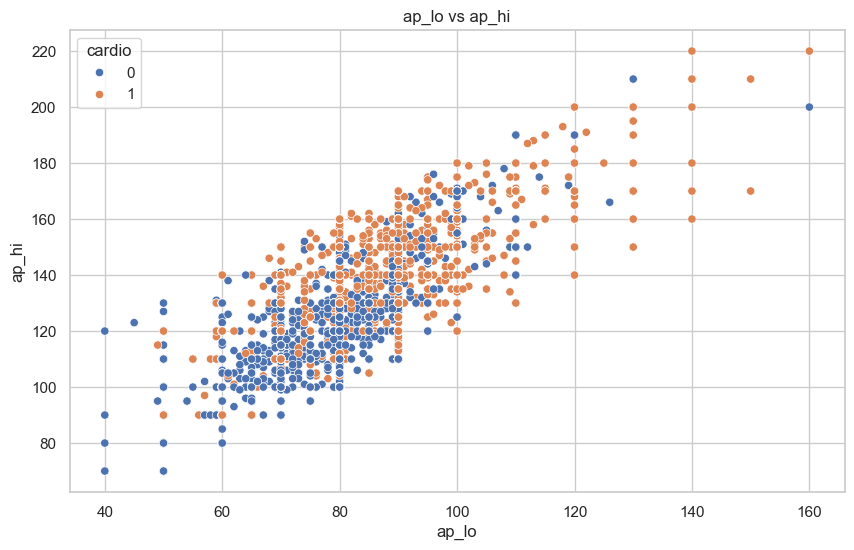

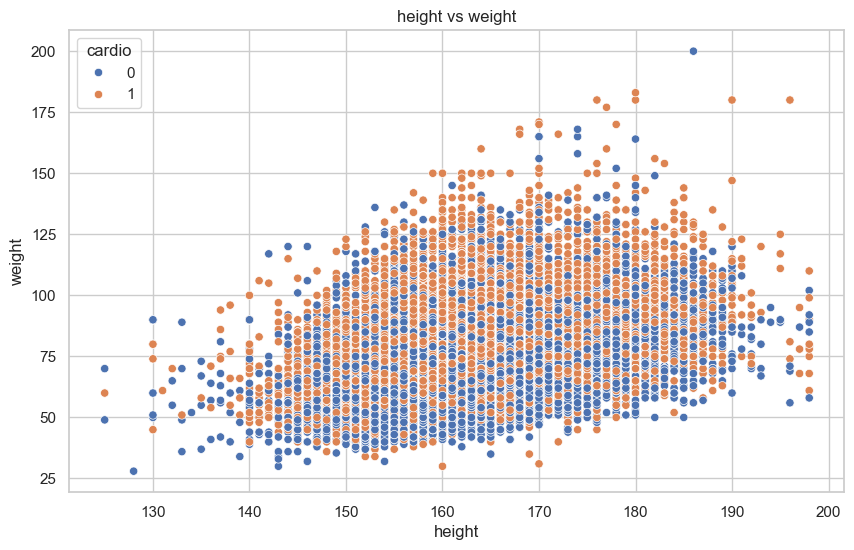

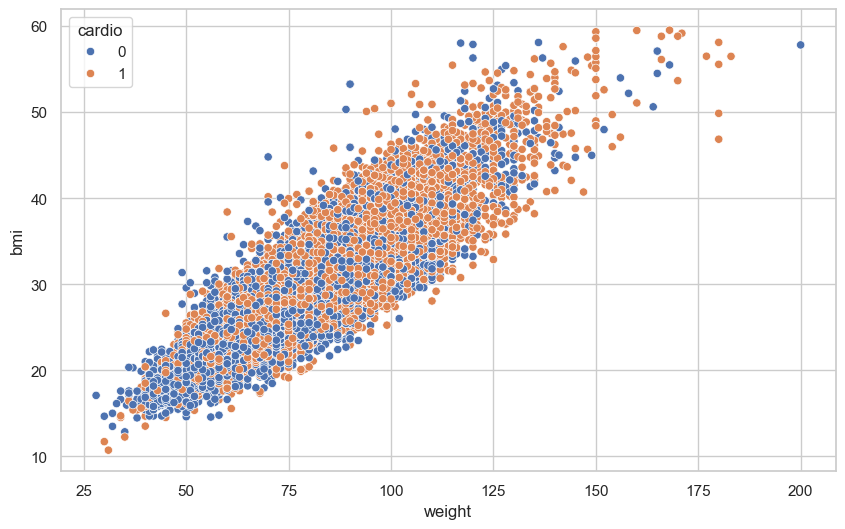

In [14]:
sns.scatterplot(x='ap_lo', y='ap_hi', hue='cardio', data=cleaned_cvd_data)
plt.title('ap_lo vs ap_hi')
plt.show()

sns.scatterplot(x="height", y="weight", hue='cardio', data=cleaned_cvd_data)
plt.title('height vs weight')
plt.show()

sns.scatterplot(x='weight', y='bmi', hue='cardio', data=cleaned_cvd_data)
plt.show()

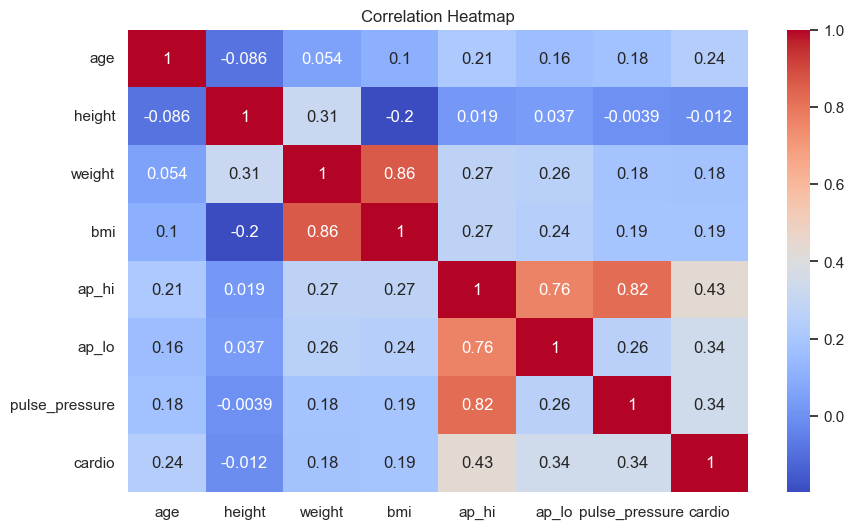

In [15]:
#Correlation Heatmap
cols = [*cont_cols, 'cardio']
sns.heatmap(cleaned_cvd_data[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Categorical Feature EDA


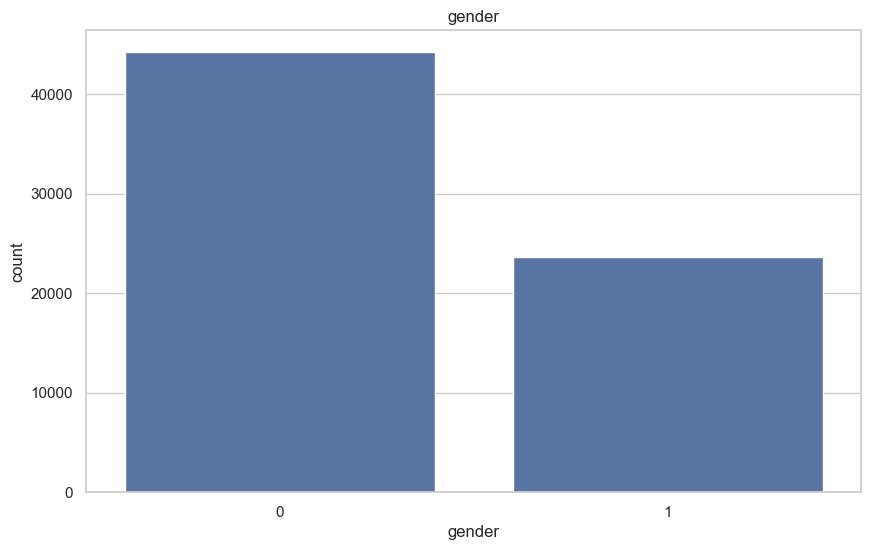

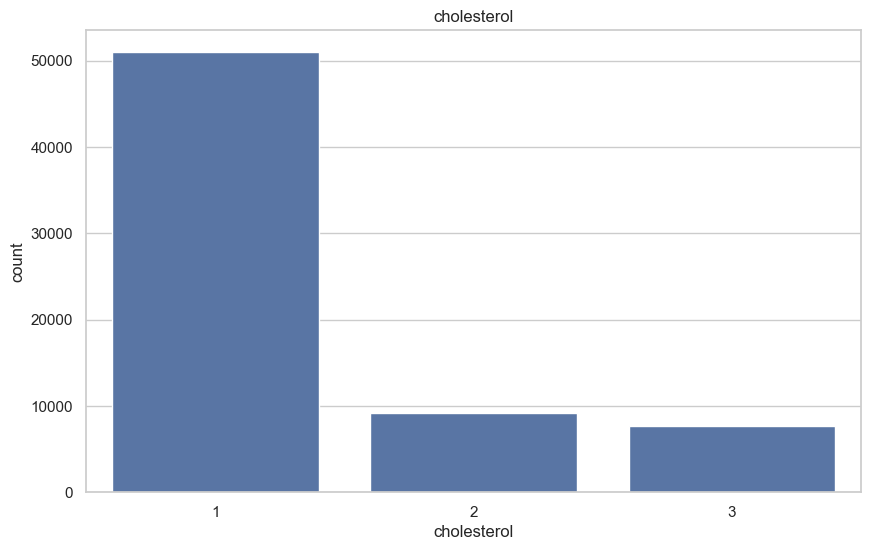

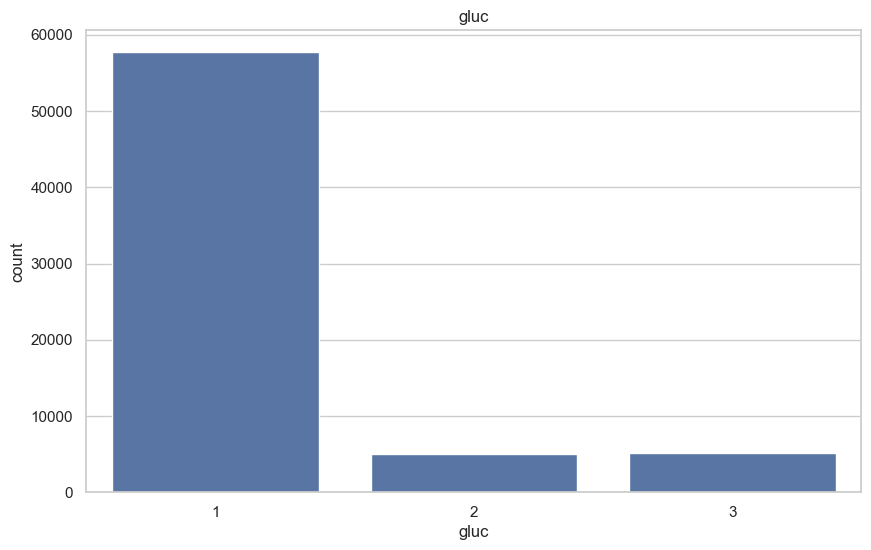

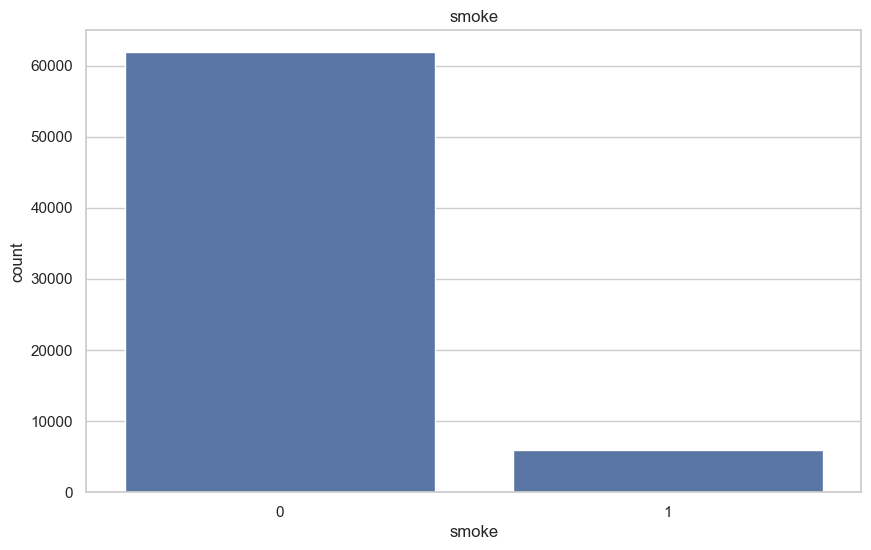

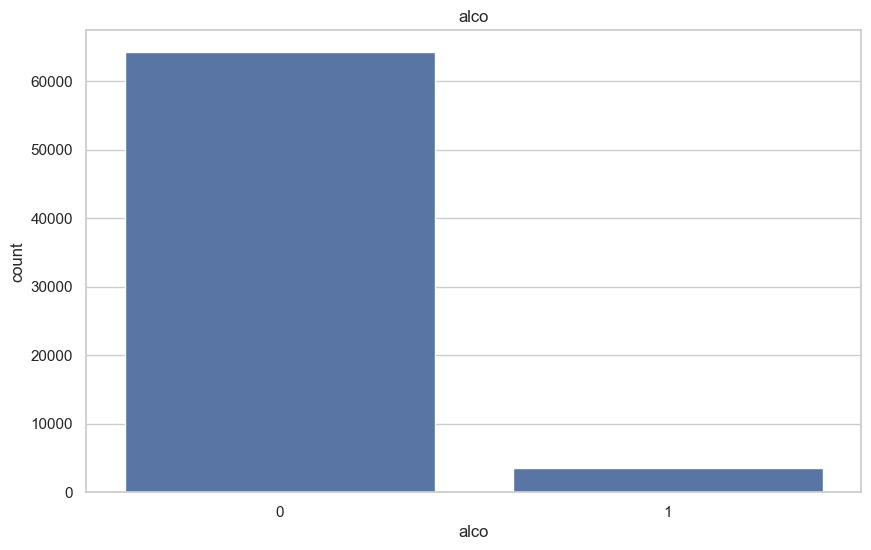

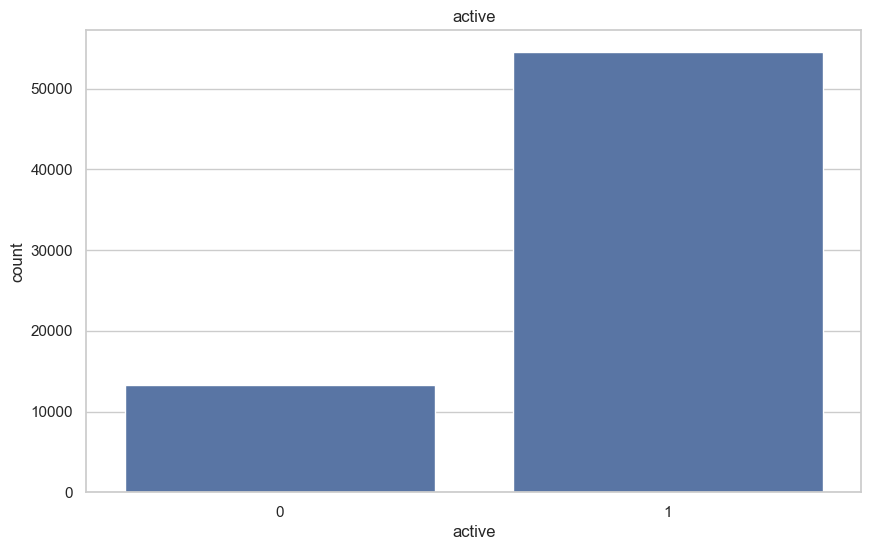

In [16]:
#Countplot of categorical features
for col in cat_cols:
    sns.countplot(data = cleaned_cvd_data, x = col)
    plt.title(f"{col}")
    plt.show()

Bivariate EDA


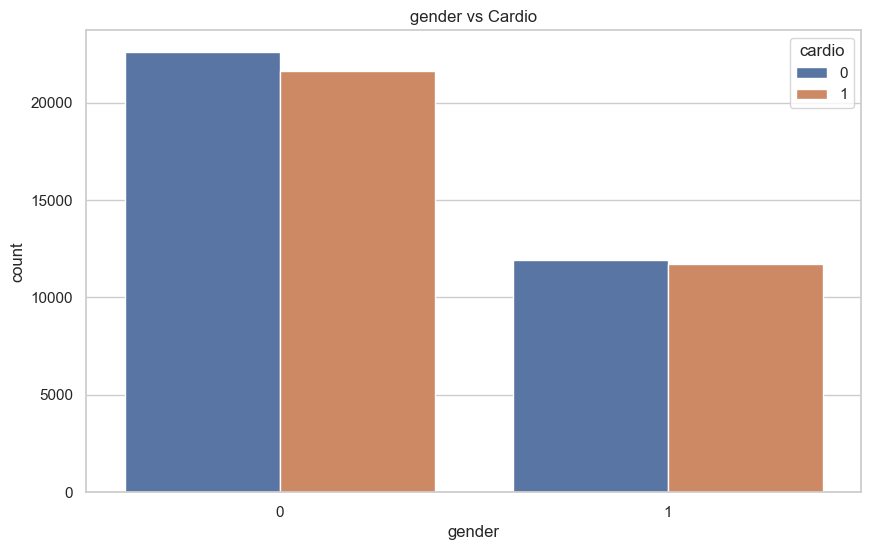

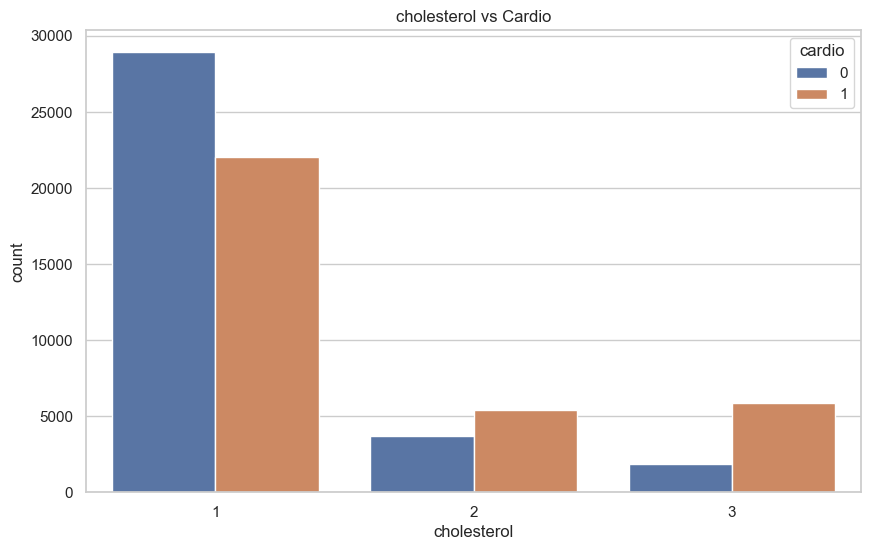

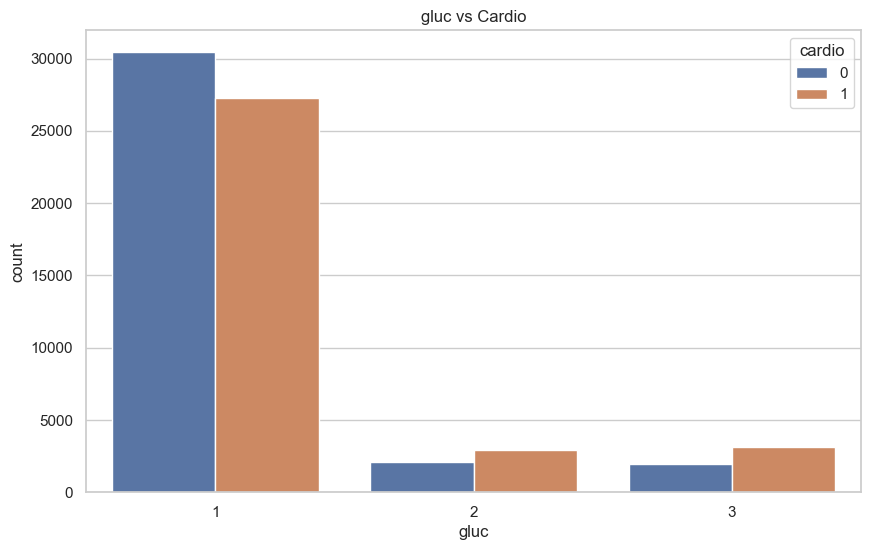

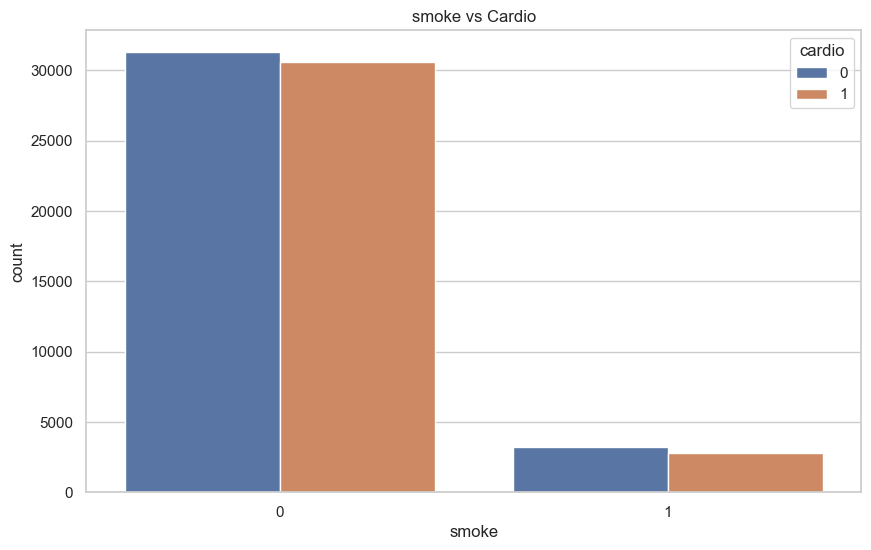

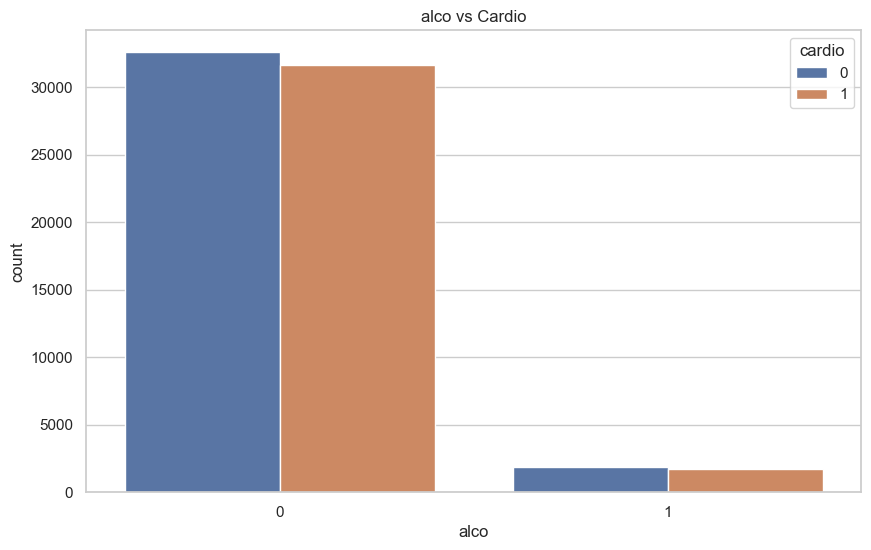

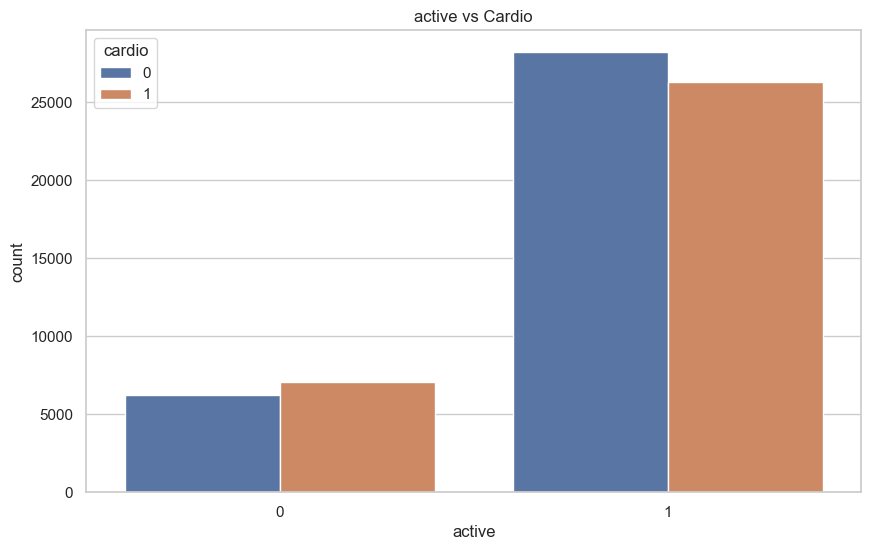

In [17]:
# relation between categorical features and cardio
for col in cat_cols:
    sns.countplot(data = cleaned_cvd_data, x = col, hue = 'cardio')
    plt.title(f"{col} vs Cardio")
    plt.show()

<Axes: xlabel='cardio', ylabel='count'>

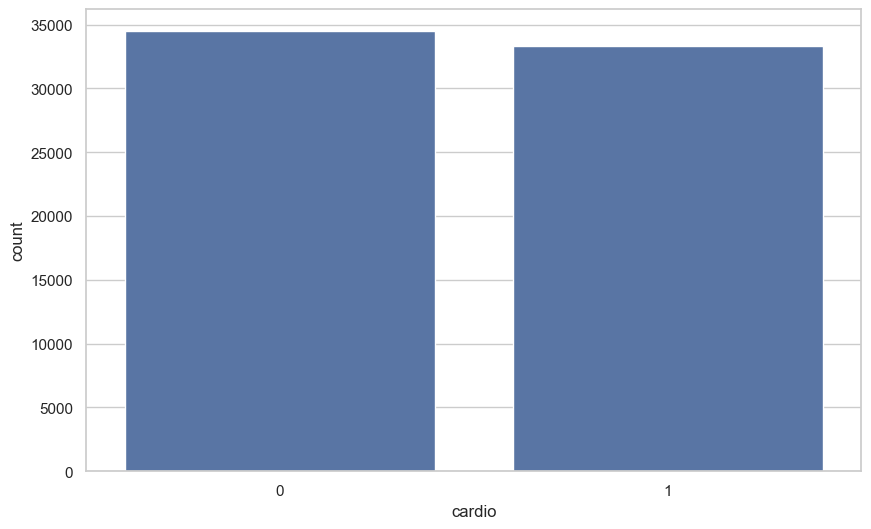

In [18]:
# Target Feature Distribution
sns.countplot(data=cleaned_cvd_data,x='cardio')

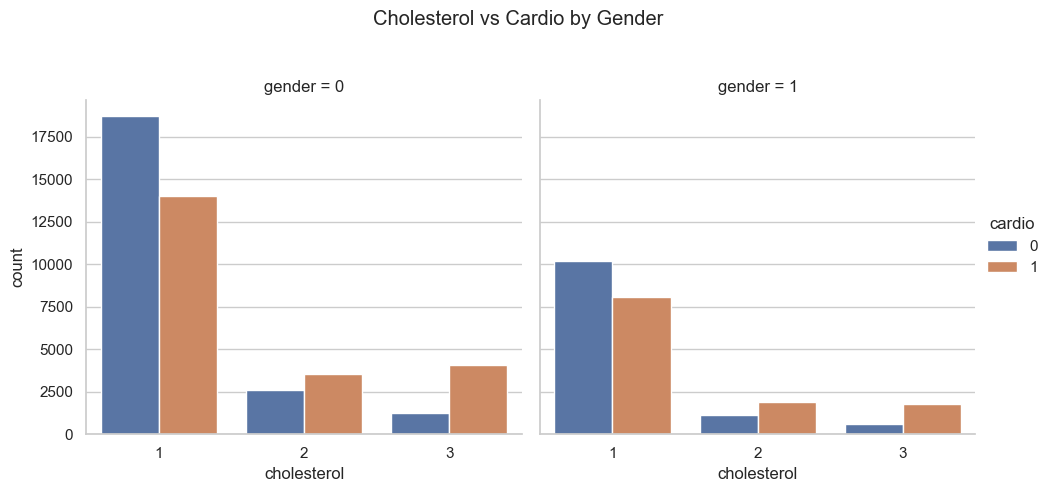

In [19]:
sns.catplot(x='cholesterol', hue='cardio', col='gender', data=cleaned_cvd_data, kind='count')
plt.subplots_adjust(top=0.8)
plt.suptitle('Cholesterol vs Cardio by Gender')
plt.show()

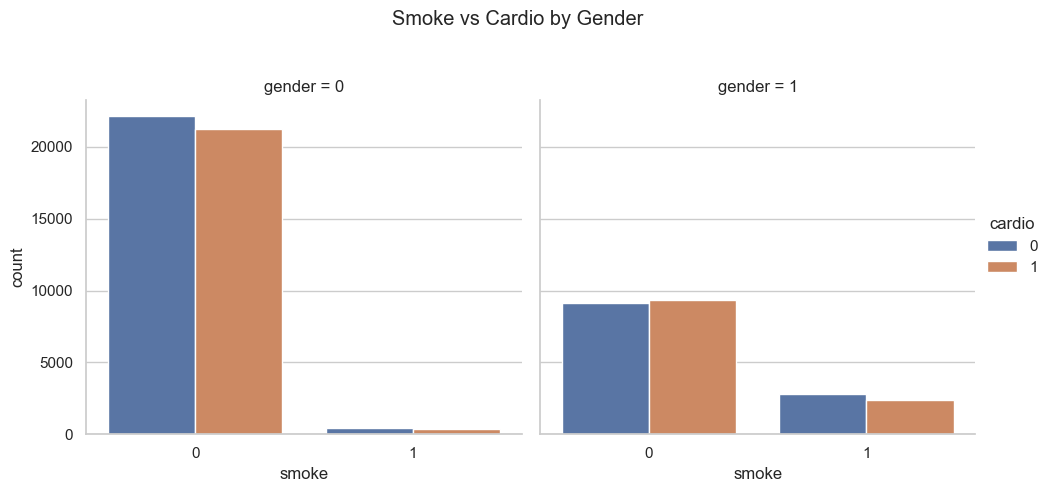

In [20]:
sns.catplot(x='smoke', hue='cardio', col='gender', data=cleaned_cvd_data, kind='count')
plt.subplots_adjust(top=0.8)
plt.suptitle('Smoke vs Cardio by Gender')
plt.show()

Split Train Validation Test: 70/10/20

In [21]:
#stratify on age, gender and cardio for fairness
cleaned_cvd_data['stratify_col'] = cleaned_cvd_data['cardio'].astype(str) + '_' + cleaned_cvd_data['gender'].astype(str) + '_' + cleaned_cvd_data['age_group'].astype(str)

In [22]:
train_validation_data, test_data = train_test_split(
    cleaned_cvd_data,
    test_size=0.20,
    stratify=cleaned_cvd_data['stratify_col'],
    random_state=42
)

In [23]:
train_data, validation_data = train_test_split(train_validation_data, test_size=0.125, stratify=train_validation_data['stratify_col'], random_state=42)

In [25]:
#drop unnecessary columns
drop_cols = ['id', 'stratify_col', 'age_group', 'bmi', 'pulse_pressure']
cont_cols.remove('bmi')
cont_cols.remove('pulse_pressure')

train_data.drop(columns=drop_cols, inplace=True)
validation_data.drop(columns=drop_cols, inplace=True)
test_data.drop(columns=drop_cols, inplace=True)

In [26]:
X_train = train_data.drop('cardio', axis=1)
y_train = train_data['cardio']

X_validation = validation_data.drop('cardio', axis=1)
y_validation = validation_data['cardio']

X_test = test_data.drop('cardio', axis=1)
y_test = test_data['cardio']

Model Preprocessor
- Scaling Numeric columns
-  One Hot Encoding ordinal columns

In [27]:
pre_processor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), cont_cols),
    ('cat', OneHotEncoder(), ordinal_cols),
    ('pass', 'passthrough', binary_cols)
], remainder='drop')

Model Training without Hyperparameter Tuning

In [28]:
models_untuned = {
    'logistic_regression': Pipeline([
        ('pre', pre_processor),
        ('model', LogisticRegression(random_state=42))
    ]),
    'knn': Pipeline([
        ('pre', pre_processor),
        ('model', KNeighborsClassifier())
    ]),
    'random_forest': Pipeline([
        ('pre', pre_processor),
        ('model', RandomForestClassifier(random_state=42))
    ]),
    'xgboost': Pipeline([
        ('pre', pre_processor),
        ('model', XGBClassifier(random_state=42))
    ]),
    'svc': Pipeline([
        ('pre', pre_processor),
        ('model', SVC(probability=True))
    ])
}

In [29]:
model_names = ['logistic_regression', 'knn', 'random_forest', 'xgboost', 'svc']
score_metrics = ['accuracy', 'recall_score', 'rmse', 'r2', 'precision_score', 'f1_score', 'roc_auc', 'brier_score']

In [30]:
def get_results(model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    
    prob_true, prob_pred = calibration_curve(y, y_proba, n_bins=10)
    
    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred)
    precision = precision_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_proba)
    brier = brier_score_loss(y, y_proba)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    cm = confusion_matrix(y, y_pred, normalize='true')
    
    return pd.Series({
        'accuracy': accuracy,
        'rmse': rmse,
        'r2': r2,
        'recall_score': recall,
        'precision_score': precision,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'brier_score': brier,
        
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'prob_true': prob_true,
        'prob_pred': prob_pred
    })

In [31]:
results_untuned = pd.DataFrame()

for name, model in models_untuned.items():
    print(f"Training tuned model: {name} : Training on {len(X_train)} samples, Testing on {len(X_test)} samples")
    model.fit(X_train, y_train)
    results_untuned[name] = get_results(model, X_test, y_test)

display(results_untuned.loc[score_metrics])

Training tuned model: logistic_regression : Training on 47481 samples, Testing on 13567 samples
Training tuned model: knn : Training on 47481 samples, Testing on 13567 samples
Training tuned model: random_forest : Training on 47481 samples, Testing on 13567 samples
Training tuned model: xgboost : Training on 47481 samples, Testing on 13567 samples
Training tuned model: svc : Training on 47481 samples, Testing on 13567 samples


,logistic_regression,knn,random_forest,xgboost,svc
accuracy,0.723815,0.693005,0.701776,0.725805,0.728385
recall_score,0.655322,0.669715,0.691004,0.678711,0.65922
rmse,0.525533,0.554071,0.546099,0.523636,0.521167
r2,-0.105049,-0.228324,-0.193229,-0.097086,-0.086764
precision_score,0.75116,0.69482,0.698969,0.741645,0.756929
f1_score,0.699976,0.682037,0.694964,0.708783,0.704704
roc_auc,0.788026,0.738687,0.760481,0.790992,0.784033
brier_score,0.187885,0.218831,0.20408,0.185323,0.188048


Hyperparameter Tuning with 5 fold grid search cross validation

In [32]:
#cross validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [33]:
gs_models = {
    'svc': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', SVC(random_state=42))
        ]),
        'param_grid': [
            {
                'model__kernel': ['rbf'],
                'model__C': [0.1, 1, 10],
                'model__gamma': ['scale', 'auto', 0.001, 0.01],
            },
        ]
    },
    'logistic_regression': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', LogisticRegression(random_state=42))
        ]),
        'param_grid': [
            {
                'model__penalty': ['l1'],
                'model__solver': ['liblinear', 'saga'],
                'model__C': np.logspace(-3, 3, 7),
                'model__max_iter': [1000, 2000, 3000, 5000]
            },
            {
                'model__penalty': ['l2'],
                'model__solver': ['lbfgs', 'newton-cg', 'sag', 'liblinear', 'saga'],
                'model__C': np.logspace(-3, 3, 7),
                'model__max_iter': [1000, 2000, 3000, 5000]
            },
            {
                'model__penalty': ['none'],
                'model__solver': ['lbfgs', 'newton-cg', 'saga'],
                'model__C': np.logspace(-3, 3, 7),
                'model__max_iter': [1000, 2000, 3000, 5000]
            },
            {
                'model__penalty': ['elasticnet'],
                'model__solver': ['saga'],
                'model__C': np.logspace(-3, 3, 7),
                'model__l1_ratio': [0.1, 0.5, 0.9],
                'model__max_iter': [1000, 2000, 3000, 5000]            
            }
        ]
    },
    'knn': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', KNeighborsClassifier())
        ]),
        'param_grid': {
            'model__n_neighbors': [3, 5, 7, 9],
            'model__metric': ['euclidean', 'manhattan', 'minkowski'],
            'model__weights': ['uniform', 'distance',],
            'model__p': [1, 2],
        }
    },
    'random_forest': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', RandomForestClassifier(random_state=42))
        ]),
        'param_grid': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [5, 10, 20, 30, None],
            'model__bootstrap': [True],
            'model__criterion': ['gini'],
            'model__max_features': ['sqrt', 'log2']
        }
    },
    'xgboost': {
        'pipeline': Pipeline([
            ('pre', pre_processor),
            ('model', XGBClassifier(random_state=42, eval_metric='logloss'))
        ]),
        'param_grid': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [3, 5, 7],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__min_child_weight': [1, 5, 10],
            'model__gamma': [0.0, 0.1, 0.5],
            'model__subsample': [0.8],
            'model__colsample_bytree': [0.8],
            'model__reg_alpha': [0, 0.01],
            'model__eval_metric': ['logloss']
        }
    },
}

In [34]:
grid_search_results = {}

for name, gs in gs_models.items():
    print(f"Running grid search for: {name}")
    gs = GridSearchCV(gs['pipeline'], gs['param_grid'], cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)

    best_params_clean = {k.replace('model__', ''): v for k, v in gs.best_params_.items()}
    
    grid_search_results[name] = {
        'best_params': best_params_clean,
        'best_score': gs.best_score_,
        'best_estimator': gs.best_estimator_
    }

Running grid search for: svc
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Running grid search for: logistic_regression
Fitting 5 folds for each of 364 candidates, totalling 1820 fits


/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
420 fits failed out of a total of 1820.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/shyket/Desktop/Dev/CVD

Running grid search for: knn
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Running grid search for: random_forest
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running grid search for: xgboost
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


In [35]:
for name, res in grid_search_results.items():
    print(f"Best parameters for {name}: {res['best_params']}")
    print(f"Best ROC-AUC for {name}: {res['best_score']:.4f}")

Best parameters for svc: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
Best ROC-AUC for svc: 0.7934
Best parameters for logistic_regression: {'C': np.float64(1.0), 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Best ROC-AUC for logistic_regression: 0.7907
Best parameters for knn: {'metric': 'manhattan', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Best ROC-AUC for knn: 0.7644
Best parameters for random_forest: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
Best ROC-AUC for random_forest: 0.7986
Best parameters for xgboost: {'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.8}
Best ROC-AUC for xgboost: 0.8013


Final model training with best parameters

In [36]:
models = {
    'logistic_regression': Pipeline([
        ('pre', pre_processor),
        ('model', LogisticRegression(random_state=42, **grid_search_results['logistic_regression']['best_params']))
    ]),
    'knn': Pipeline([
        ('pre', pre_processor),
        ('model', KNeighborsClassifier(**grid_search_results['knn']['best_params']))
    ]),
    'random_forest': Pipeline([
        ('pre', pre_processor),
        ('model', RandomForestClassifier(random_state=42, **grid_search_results['random_forest']['best_params']))
    ]),
    'xgboost': Pipeline([
        ('pre', pre_processor),
        ('model', XGBClassifier(random_state=42,  **grid_search_results['xgboost']['best_params']))
    ]),
    'svc': Pipeline([
        ('pre', pre_processor),
        ('model', SVC(probability=True, random_state=42, **grid_search_results['svc']['best_params']))
    ])
}

In [37]:
for name, pipeline in models.items():
    print(f"Training tuned model: {name} : Training on {len(X_train)} samples, Testing on {len(X_test)} samples")
    pipeline.fit(X_train, y_train)

Training tuned model: logistic_regression : Training on 47481 samples, Testing on 13567 samples
Training tuned model: knn : Training on 47481 samples, Testing on 13567 samples
Training tuned model: random_forest : Training on 47481 samples, Testing on 13567 samples
Training tuned model: xgboost : Training on 47481 samples, Testing on 13567 samples
Training tuned model: svc : Training on 47481 samples, Testing on 13567 samples


In [38]:
results_tuned = pd.DataFrame()
score_metrics = ['accuracy', 'recall_score', 'rmse', 'r2', 'precision_score', 'f1_score', 'roc_auc', 'brier_score']

for name, model in models.items():    
    results_tuned[name] = get_results(model, X_test, y_test)

display(results_tuned.loc[score_metrics])

,logistic_regression,knn,random_forest,xgboost,svc
accuracy,0.72411,0.710621,0.728901,0.728532,0.726985
recall_score,0.655472,0.683358,0.65937,0.678261,0.649325
rmse,0.525252,0.537939,0.520672,0.521025,0.522509
r2,-0.103869,-0.157839,-0.0847,-0.086174,-0.092367
precision_score,0.75159,0.715317,0.757753,0.746411,0.760358
f1_score,0.700248,0.698973,0.705147,0.710706,0.700469
roc_auc,0.788018,0.761062,0.7948,0.795855,0.790216
brier_score,0.187888,0.202579,0.183512,0.182822,0.185644


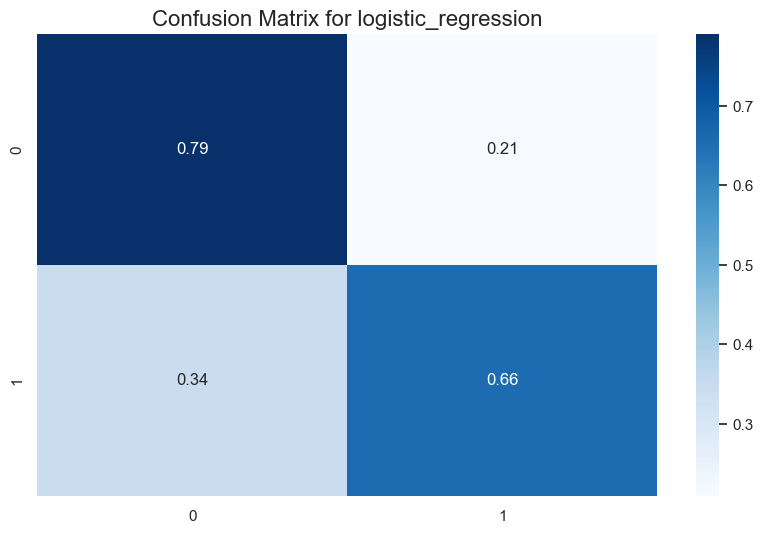

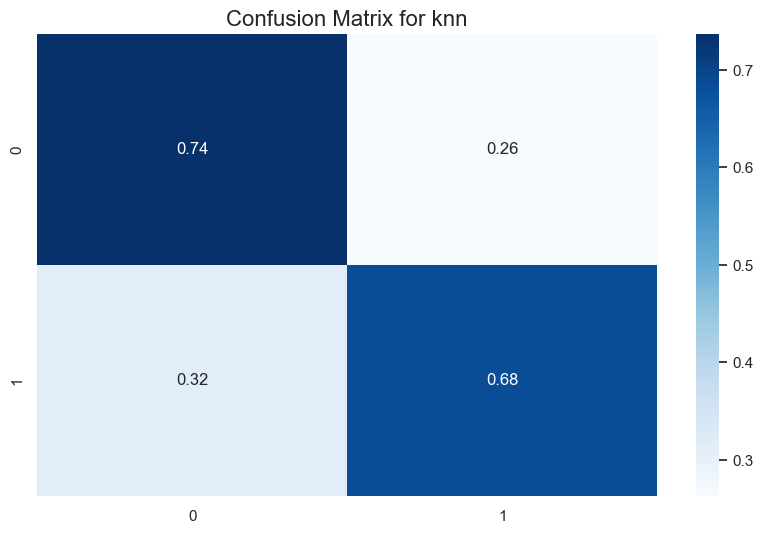

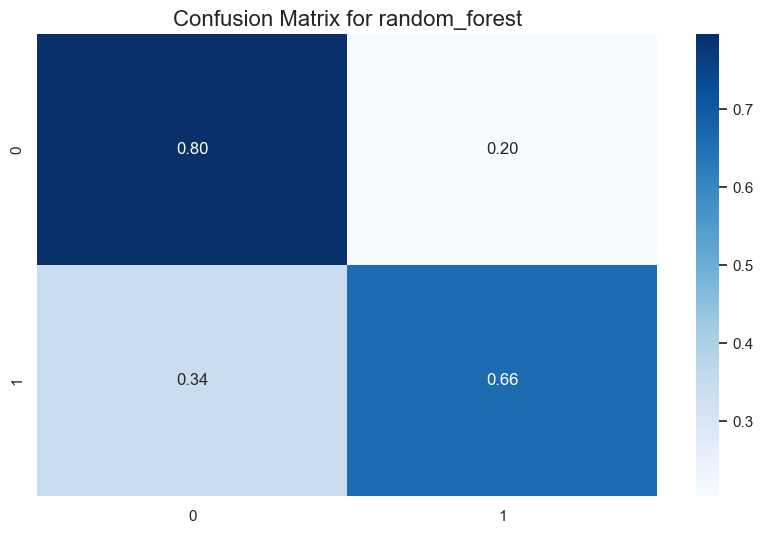

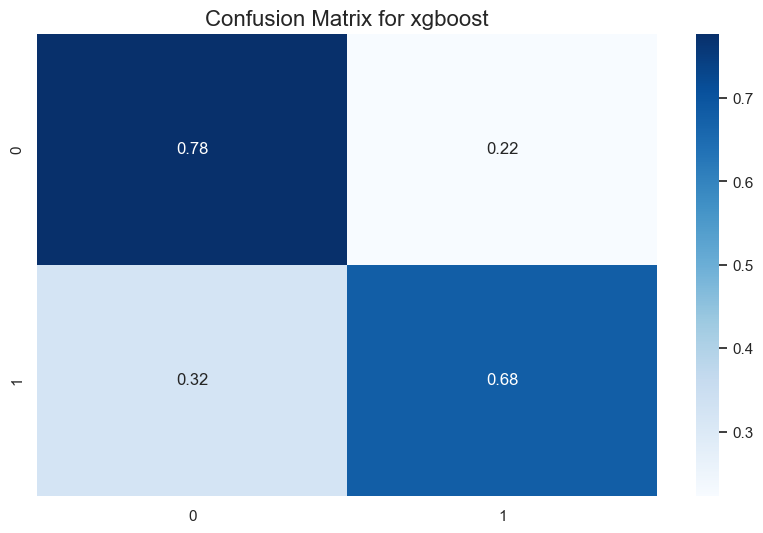

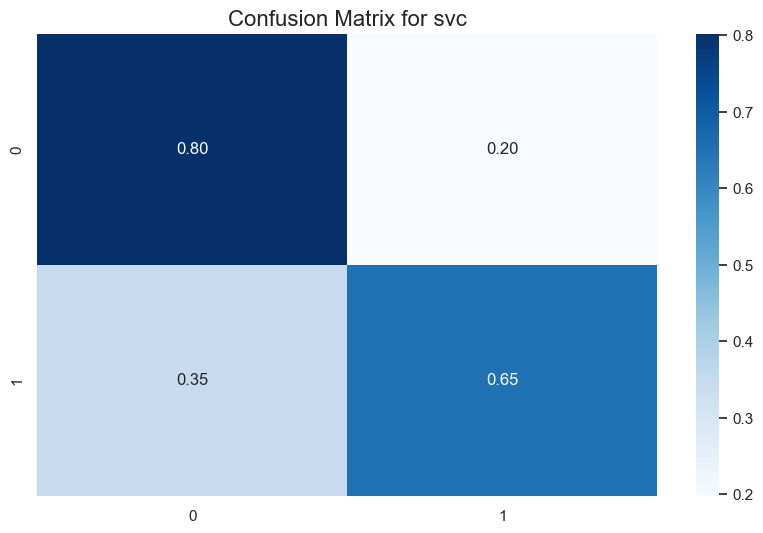

In [39]:
for name in results_tuned:
    cm = results_tuned[name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f"Confusion Matrix for {name}", fontsize=16)
    plt.show()

Model Calibration: isotonic, platt scaling

In [40]:
calibrated_models_isotonic = {}
calibrated_models_platt = {}

for name, model in models.items():
    print(f"Calibrating model: {name} with isotonic regression")
    iso_calibrator = CalibratedClassifierCV(FrozenEstimator(model), method='isotonic')
    iso_calibrator.fit(X_validation, y_validation)
    calibrated_models_isotonic[name] = iso_calibrator
    
    print(f"Calibrating model: {name} with Platt scaling")
    platt_calibrator = CalibratedClassifierCV(FrozenEstimator(model), method='sigmoid')
    platt_calibrator.fit(X_validation, y_validation)
    calibrated_models_platt[name] = platt_calibrator

Calibrating model: logistic_regression with isotonic regression
Calibrating model: logistic_regression with Platt scaling
Calibrating model: knn with isotonic regression
Calibrating model: knn with Platt scaling
Calibrating model: random_forest with isotonic regression
Calibrating model: random_forest with Platt scaling
Calibrating model: xgboost with isotonic regression
Calibrating model: xgboost with Platt scaling
Calibrating model: svc with isotonic regression
Calibrating model: svc with Platt scaling


In [41]:
results_calibrated_isotonic = {}
results_calibrated_platt = {}

for name, model in calibrated_models_isotonic.items():
    results_calibrated_isotonic[name] = get_results(model, X_test, y_test)

for name, model in calibrated_models_platt.items():    
    results_calibrated_platt[name] = get_results(model, X_test, y_test)

Calibration Curve

In [42]:
def display_calibration_curve(name, label, prob_true, prob_pred):
    plt.plot(prob_pred, prob_true, marker='o', label=label)
    plt.plot([0, 1], [0, 1], '--', label='Perfect Calibration')
    plt.title(f"Calibration Curve — {name} - {label}")
    plt.xlabel("Predicted Probability")
    plt.ylabel("True Probability")
    plt.legend()
    plt.grid()
    plt.show()

'Calibration Curves for logistic_regression:'

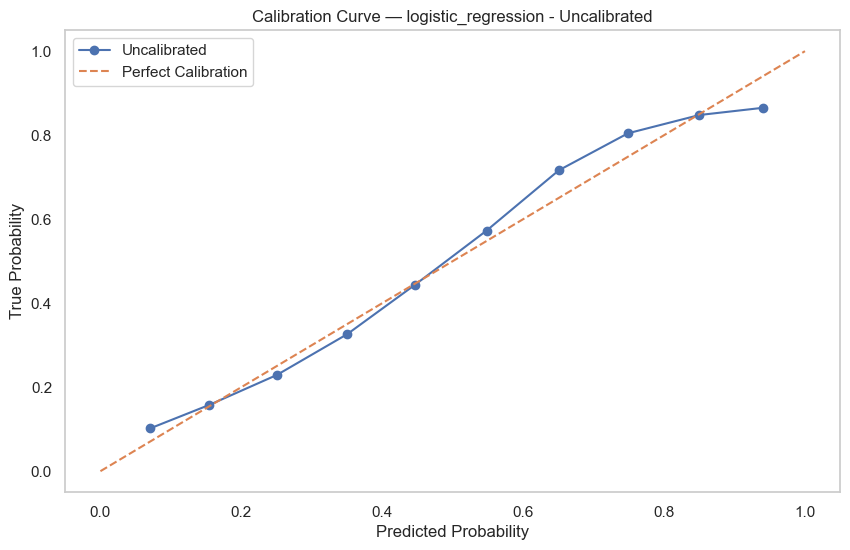

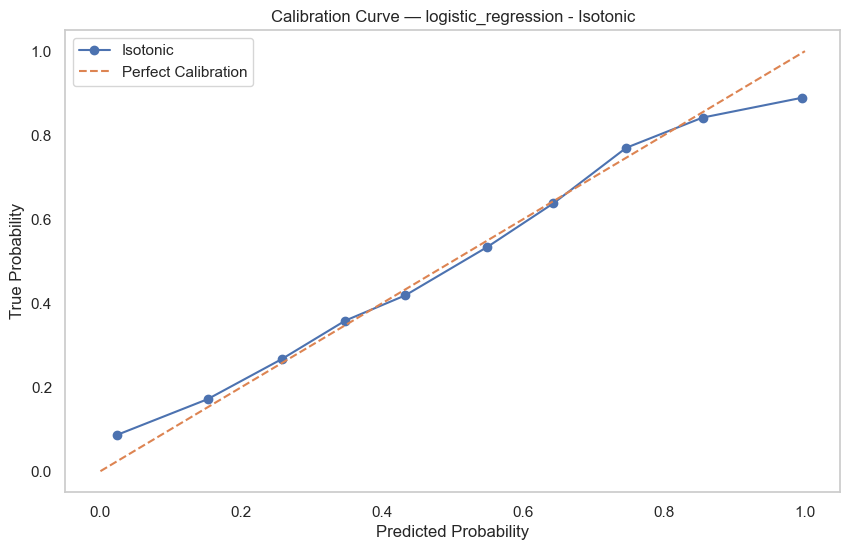

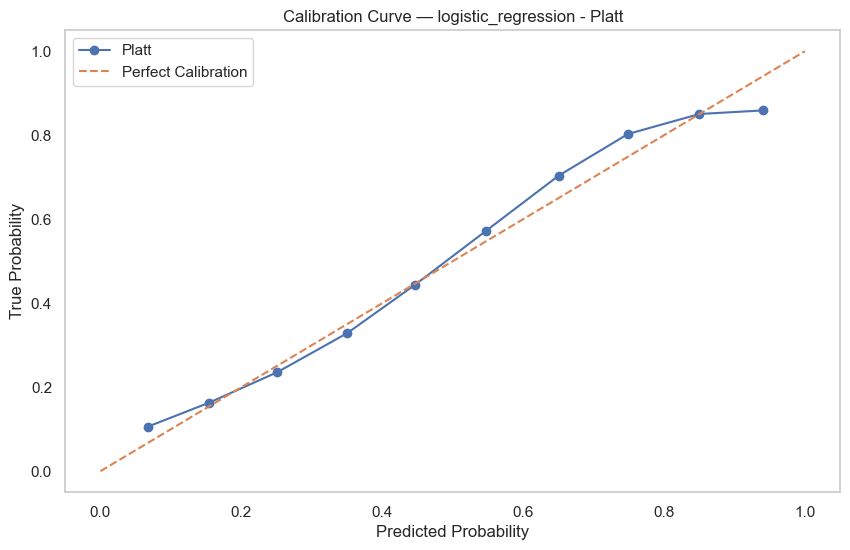

'Calibration Curves for knn:'

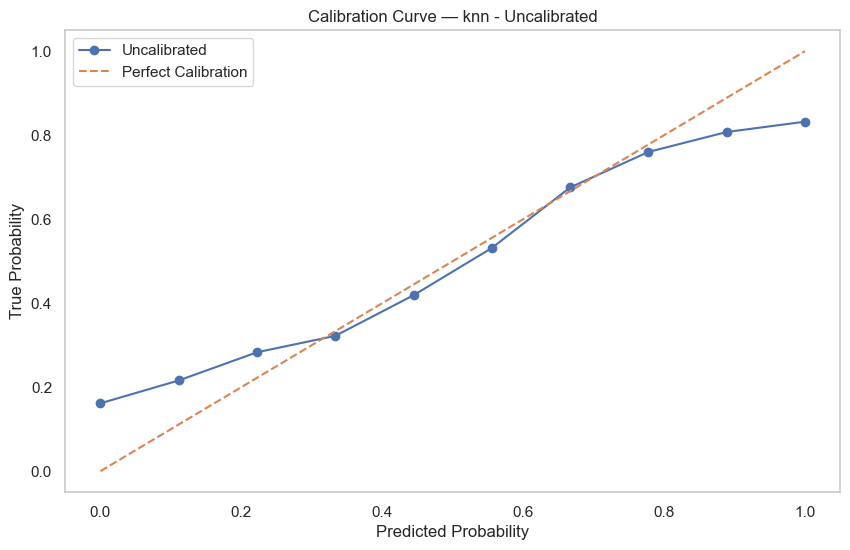

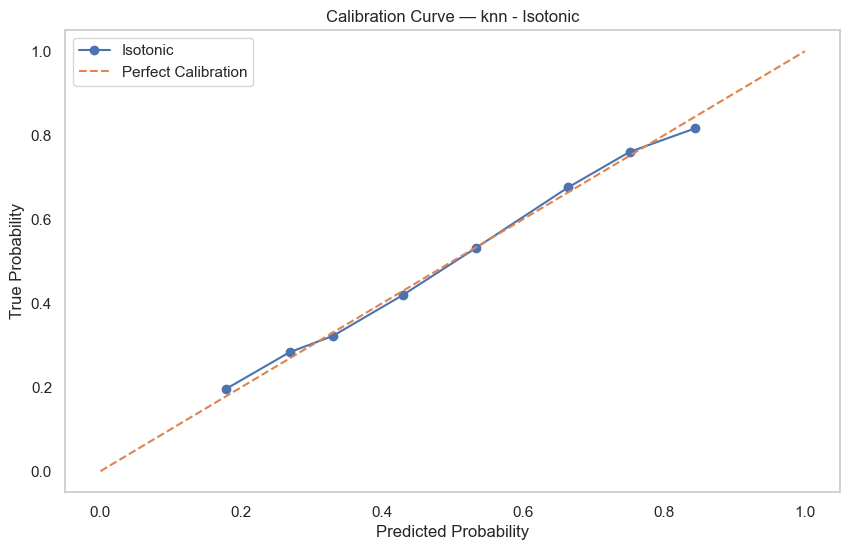

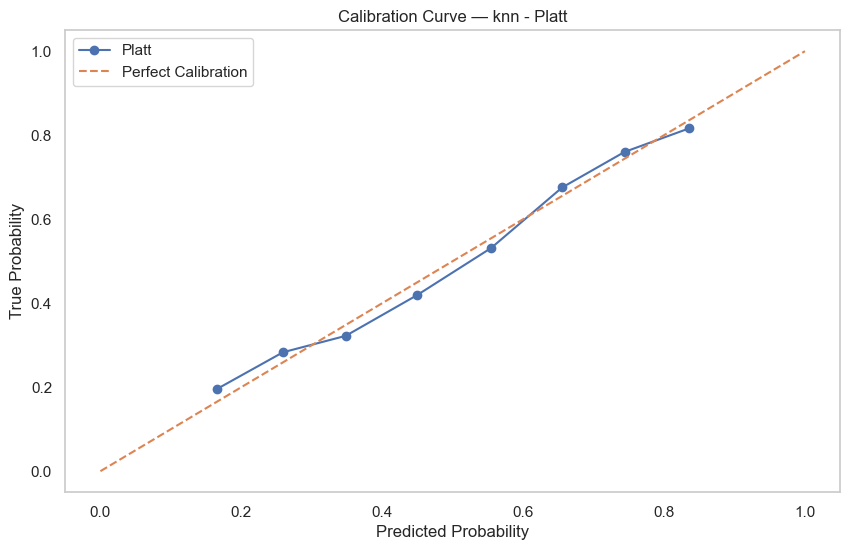

'Calibration Curves for random_forest:'

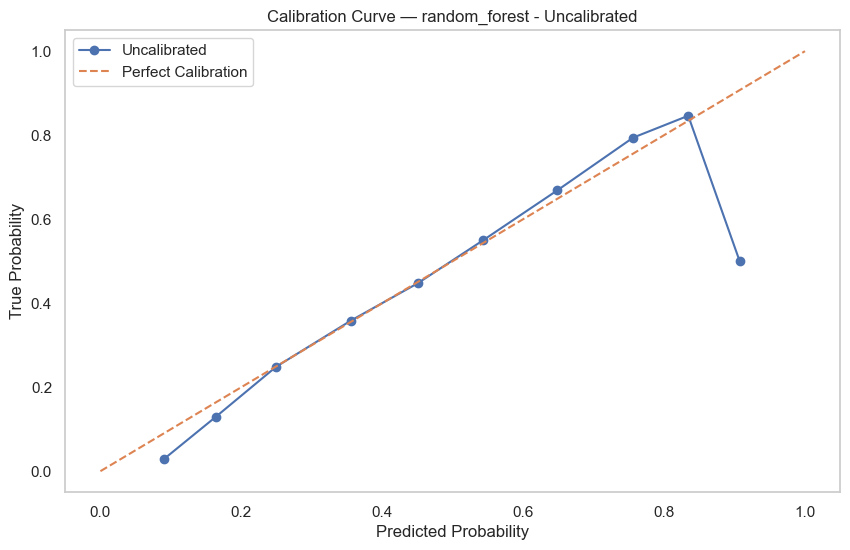

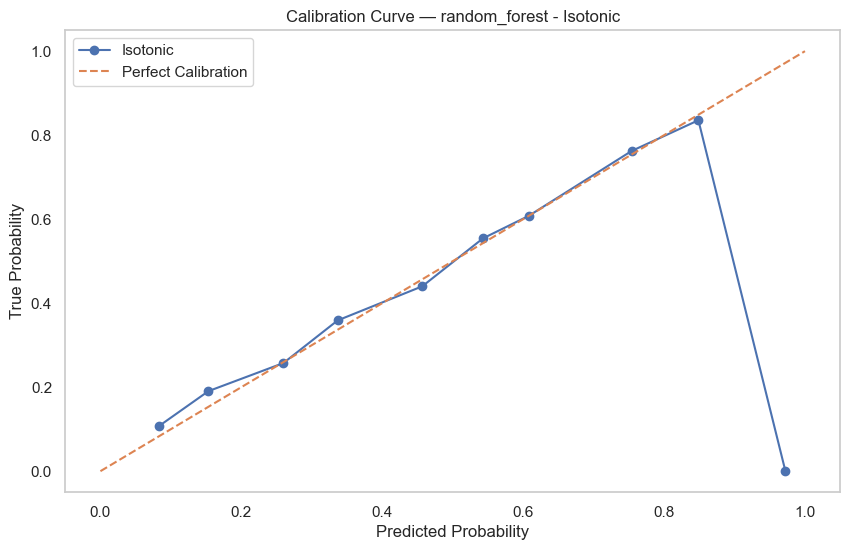

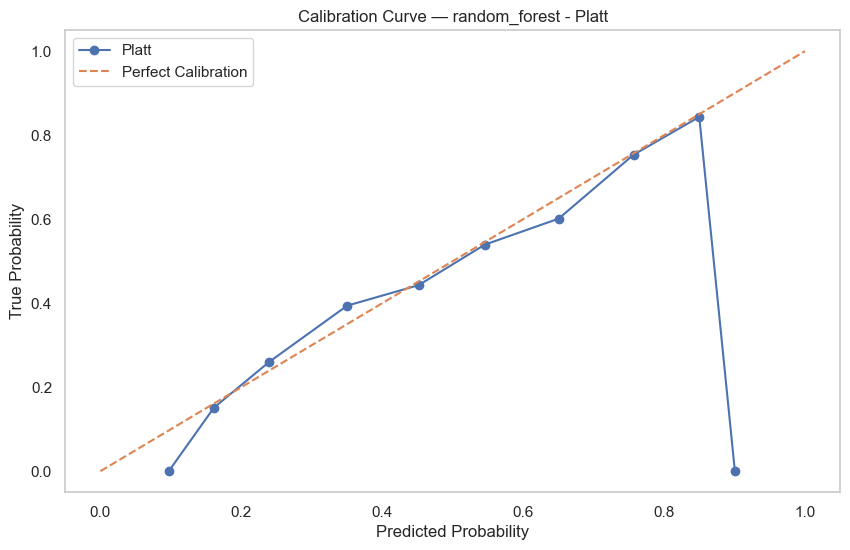

'Calibration Curves for xgboost:'

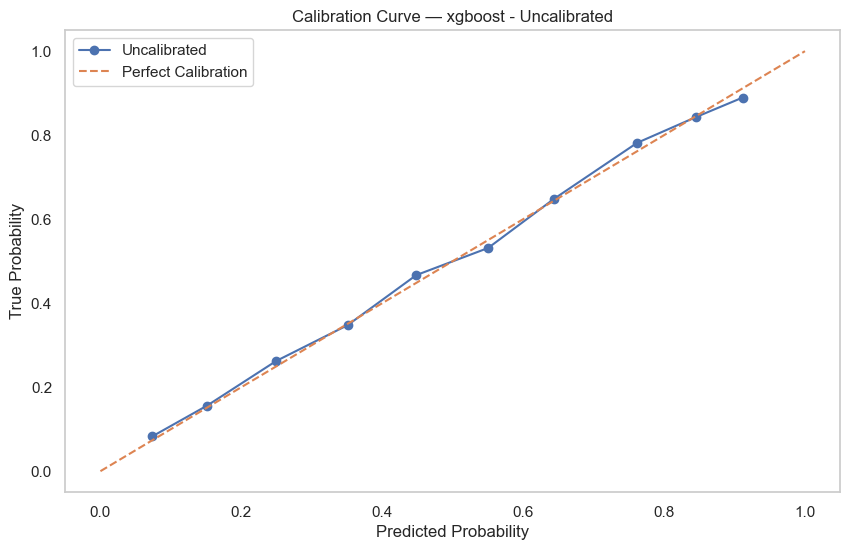

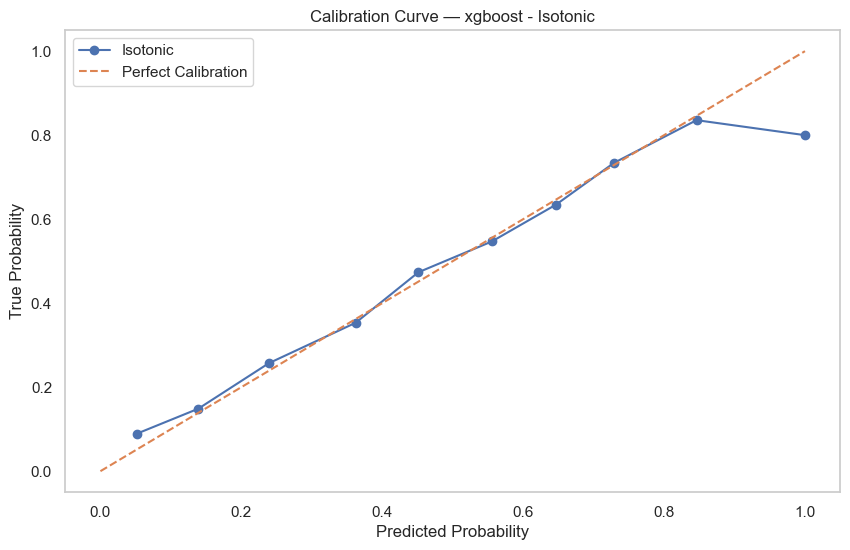

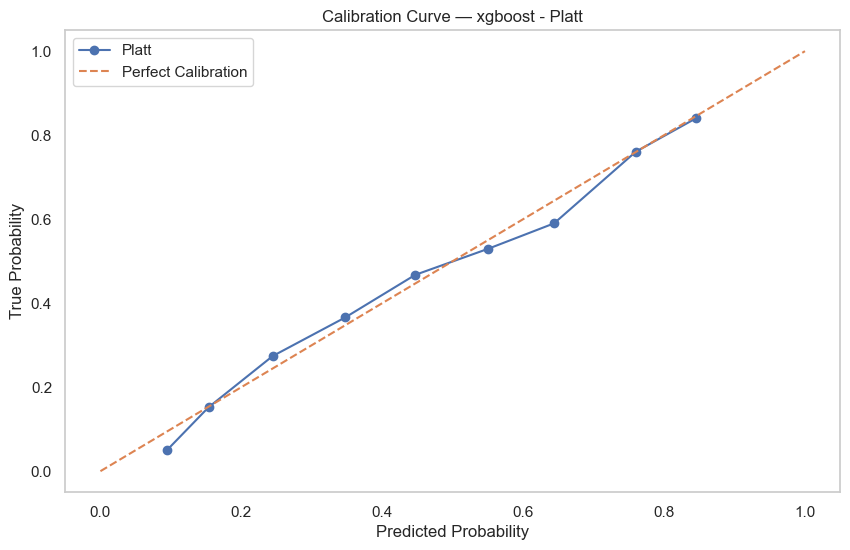

'Calibration Curves for svc:'

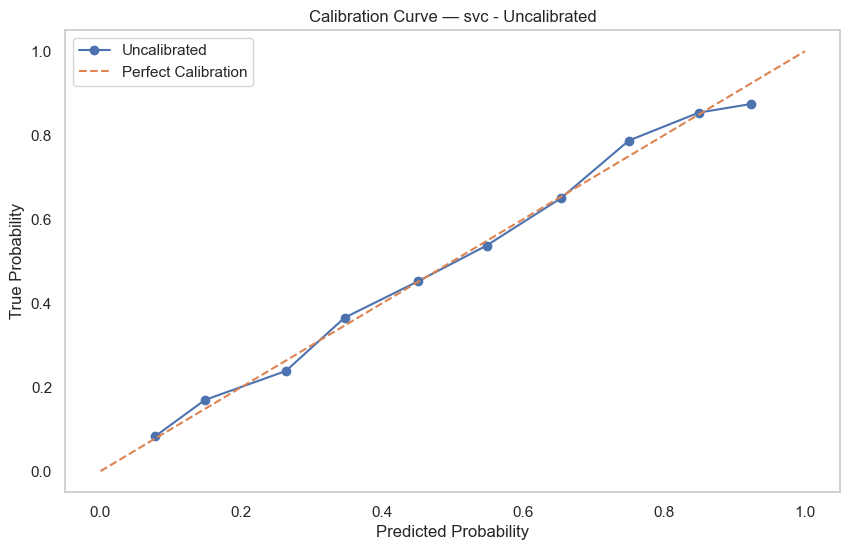

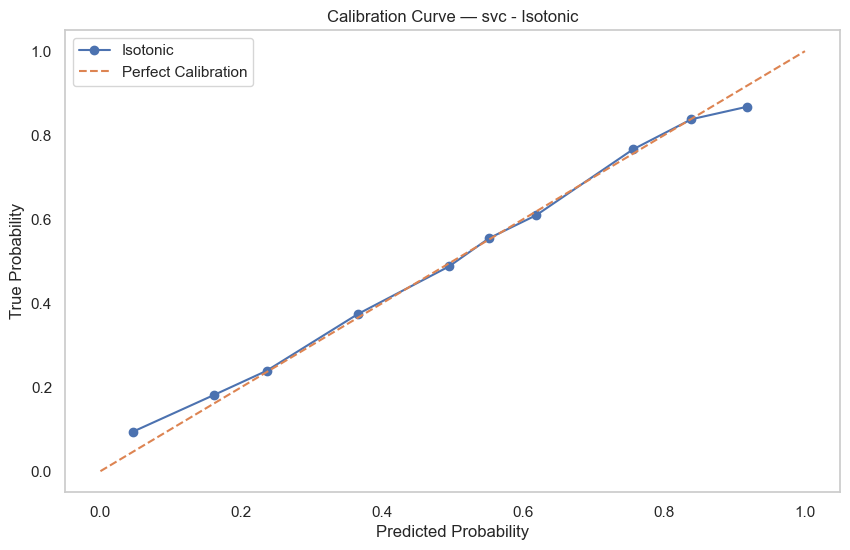

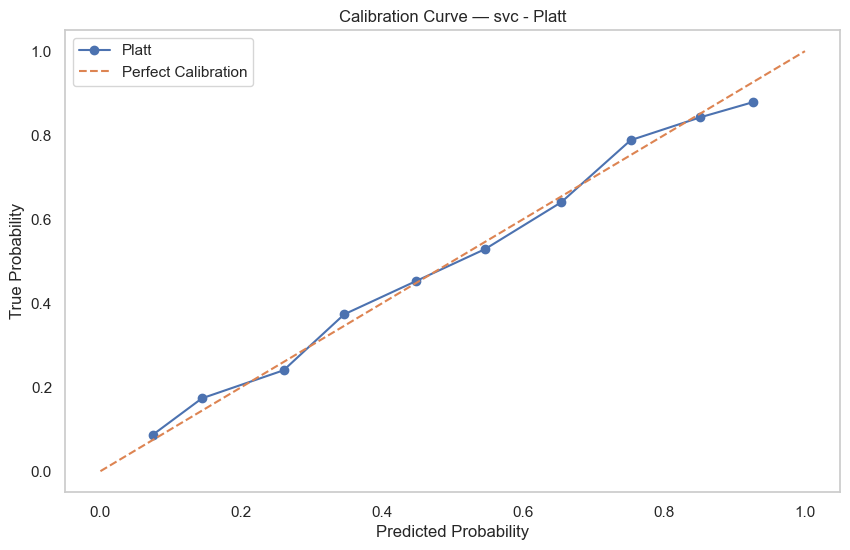

In [43]:
for name in model_names:
    display(f'Calibration Curves for {name}:')
    display_calibration_curve(name, 'Uncalibrated', results_tuned[name]['prob_true'], results_tuned[name]['prob_pred'])
    display_calibration_curve(name, 'Isotonic', results_calibrated_isotonic[name]['prob_true'], results_calibrated_isotonic[name]['prob_pred'])
    display_calibration_curve(name, 'Platt', results_calibrated_platt[name]['prob_true'], results_calibrated_platt[name]['prob_pred'])

Calibration Streatagy Comparison

In [44]:
for name in model_names:
    comparison = pd.DataFrame()

    comparison['Uncalibrated'] = results_tuned[name]
    comparison['Isotonic'] = results_calibrated_isotonic[name]
    comparison['Platt'] = results_calibrated_platt[name]
    
    display(f'calibration Comparison for {name}:')
    display(comparison.loc[score_metrics])

'calibration Comparison for logistic_regression:'

,Uncalibrated,Isotonic,Platt
accuracy,0.72411,0.725363,0.724257
recall_score,0.655472,0.692654,0.656672
rmse,0.525252,0.524058,0.525112
r2,-0.103869,-0.098856,-0.103279
precision_score,0.75159,0.733799,0.751158
f1_score,0.700248,0.712633,0.700744
roc_auc,0.788018,0.787409,0.788018
brier_score,0.187888,0.186865,0.187746


'calibration Comparison for knn:'

,Uncalibrated,Isotonic,Platt
accuracy,0.710621,0.710621,0.710621
recall_score,0.683358,0.683358,0.683358
rmse,0.537939,0.537939,0.537939
r2,-0.157839,-0.157839,-0.157839
precision_score,0.715317,0.715317,0.715317
f1_score,0.698973,0.698973,0.698973
roc_auc,0.761062,0.761062,0.761062
brier_score,0.202579,0.197076,0.197443


'calibration Comparison for random_forest:'

,Uncalibrated,Isotonic,Platt
accuracy,0.728901,0.730007,0.729859
recall_score,0.65937,0.670465,0.667916
rmse,0.520672,0.519609,0.519751
r2,-0.0847,-0.080276,-0.080866
precision_score,0.757753,0.753242,0.754445
f1_score,0.705147,0.709447,0.708549
roc_auc,0.7948,0.793298,0.7948
brier_score,0.183512,0.183869,0.183675


'calibration Comparison for xgboost:'

,Uncalibrated,Isotonic,Platt
accuracy,0.728532,0.728827,0.728606
recall_score,0.678261,0.654423,0.684558
rmse,0.521025,0.520742,0.520955
r2,-0.086174,-0.084995,-0.085879
precision_score,0.746411,0.760585,0.743164
f1_score,0.710706,0.703522,0.712658
roc_auc,0.795855,0.794971,0.795855
brier_score,0.182822,0.183129,0.183182


'calibration Comparison for svc:'

,Uncalibrated,Isotonic,Platt
accuracy,0.726985,0.7261,0.72669
recall_score,0.649325,0.628336,0.672414
rmse,0.522509,0.523354,0.522791
r2,-0.092367,-0.095906,-0.093547
precision_score,0.760358,0.772108,0.746505
f1_score,0.700469,0.692842,0.707525
roc_auc,0.790216,0.789402,0.79022
brier_score,0.185644,0.185455,0.185623


update models with calibration

In [45]:
final_models = {}
final_results = {}

for name in model_names:
    uncalibrated_brier = results_tuned[name]['brier_score']
    iso_brier = results_calibrated_isotonic[name]['brier_score']
    platt_brier = results_calibrated_platt[name]['brier_score']
    
    if uncalibrated_brier <= iso_brier and uncalibrated_brier <= platt_brier:
        final_models[name] = models[name]
        final_results[name] = results_tuned[name]
    elif iso_brier <= uncalibrated_brier and iso_brier <= platt_brier:
        final_models[name] = calibrated_models_isotonic[name]
        final_results[name] = results_calibrated_isotonic[name]
    elif platt_brier <= uncalibrated_brier and platt_brier <= iso_brier:
        final_models[name] = calibrated_models_platt[name]
        final_results[name] = results_calibrated_platt[name]

Fairness Evaluation

In [46]:
#age group fairness evaluation
age_group_results = {}

test_data['age_group'] = pd.cut(
    test_data['age'],
    bins=age_group_bin,
    labels=age_group_labels,
    include_lowest=True
)

for name in model_names:
    model = final_models[name]
    result = pd.DataFrame()

    for group in age_group_labels:
        group_indices = test_data[test_data['age_group'] == group].index
    
        X_group = X_test.loc[group_indices]
        y_group = y_test.loc[group_indices]
        
        if len(y_group) == 0:
            continue
        
        result[group] = get_results(model, X_group, y_group)
        
    age_group_results[name] = {}
    age_group_results[name]['results'] = result
    age_group_results[name]['EOD'] = result.loc['recall_score'].max() - result.loc['recall_score'].min()
    
    display("Age Group Performance for Model: " + name) 
    display(result.loc[score_metrics])
    display(f"Equal Opportunity Difference (EOD): {age_group_results[name]['EOD']:.4f}")

'Age Group Performance for Model: logistic_regression'

,<45,45-49,50-54,55-59,60-64
accuracy,0.791874,0.760988,0.707952,0.677715,0.71285
recall_score,0.446381,0.587763,0.66452,0.737559,0.883969
rmse,0.456208,0.488889,0.540415,0.567701,0.535863
r2,0.025757,0.017081,-0.168804,-0.311272,-0.349099
precision_score,0.7891,0.785523,0.716993,0.705411,0.747579
f1_score,0.570205,0.672404,0.68976,0.721127,0.810073
roc_auc,0.801441,0.785851,0.758742,0.735033,0.713886
brier_score,0.153914,0.176499,0.197613,0.205715,0.188438


'Equal Opportunity Difference (EOD): 0.4376'

'Age Group Performance for Model: knn'

,<45,45-49,50-54,55-59,60-64
accuracy,0.791874,0.742989,0.686499,0.665286,0.691698
recall_score,0.542895,0.598796,0.629977,0.716082,0.849618
rmse,0.456208,0.506963,0.559912,0.578545,0.55525
r2,0.025757,-0.056939,-0.254662,-0.361845,-0.448481
precision_score,0.715548,0.736128,0.698701,0.698875,0.742495
f1_score,0.617378,0.660398,0.662562,0.707374,0.792453
roc_auc,0.765781,0.764295,0.727923,0.700144,0.673117
brier_score,0.160785,0.185258,0.208096,0.217805,0.20088


'Equal Opportunity Difference (EOD): 0.3067'

'Age Group Performance for Model: random_forest'

,<45,45-49,50-54,55-59,60-64
accuracy,0.794362,0.764755,0.705664,0.690441,0.711793
recall_score,0.520107,0.585757,0.608314,0.666841,0.850382
rmse,0.453474,0.48502,0.542528,0.55638,0.536849
r2,0.037402,0.032573,-0.177962,-0.259495,-0.354068
precision_score,0.737643,0.796726,0.742673,0.756387,0.761449
f1_score,0.610063,0.675145,0.668812,0.708797,0.803462
roc_auc,0.812271,0.794333,0.758364,0.743637,0.721394
brier_score,0.149811,0.1719,0.196206,0.201385,0.185764


'Equal Opportunity Difference (EOD): 0.3303'

'Age Group Performance for Model: xgboost'

,<45,45-49,50-54,55-59,60-64
accuracy,0.791045,0.769778,0.707094,0.688665,0.707562
recall_score,0.497319,0.602808,0.614754,0.671032,0.932061
rmse,0.457116,0.479814,0.541208,0.557974,0.540775
r2,0.021876,0.05323,-0.172239,-0.26672,-0.373945
precision_score,0.742,0.796026,0.741525,0.75132,0.724629
f1_score,0.595506,0.686073,0.672215,0.70891,0.815359
roc_auc,0.811664,0.791956,0.762027,0.745221,0.718911
brier_score,0.148952,0.171519,0.195148,0.200828,0.185344


'Equal Opportunity Difference (EOD): 0.4347'

'Age Group Performance for Model: svc'

,<45,45-49,50-54,55-59,60-64
accuracy,0.792703,0.755965,0.706522,0.688961,0.705976
recall_score,0.50134,0.549649,0.581382,0.65165,0.787786
rmse,0.455299,0.493999,0.541736,0.557708,0.54224
r2,0.029639,-0.003576,-0.174528,-0.265516,-0.381398
precision_score,0.74502,0.803519,0.761503,0.76319,0.787786
f1_score,0.599359,0.65277,0.659363,0.703023,0.787786
roc_auc,0.7929,0.785641,0.757549,0.737802,0.716585
brier_score,0.152962,0.175569,0.197429,0.203169,0.185597


'Equal Opportunity Difference (EOD): 0.2864'

In [47]:
# gender fairness evaluation
gender_group_results = {}

gender_groups = test_data['gender'].unique()

for name in model_names:
    model = final_models[name]
    result = pd.DataFrame()

    for group in gender_groups:
        group_indices = test_data[test_data['gender'] == group].index
    
        X_group = X_test.loc[group_indices]
        y_group = y_test.loc[group_indices]
        
        if len(y_group) == 0:
            continue
        
        result[group] = get_results(model, X_group, y_group)
        
    gender_group_results[name] = {}
    gender_group_results[name]['results'] = result
    gender_group_results[name]['EOD'] = result.loc['recall_score'].max() - result.loc['recall_score'].min()
    
    display("Gender Group Performance for Model: " + name) 
    display(result.loc[score_metrics])
    display(f"Equal Opportunity Difference (EOD): {gender_group_results[name]['EOD']:.4f}")

'Gender Group Performance for Model: logistic_regression'

,0,1
accuracy,0.72498,0.72608
recall_score,0.692788,0.692406
rmse,0.524423,0.523374
r2,-0.100593,-0.095745
precision_score,0.730976,0.739071
f1_score,0.71137,0.714978
roc_auc,0.791561,0.779214
brier_score,0.185198,0.189985


'Equal Opportunity Difference (EOD): 0.0004'

'Gender Group Performance for Model: knn'

,0,1
accuracy,0.711976,0.708086
recall_score,0.68516,0.680034
rmse,0.536679,0.54029
r2,-0.152635,-0.167722
precision_score,0.714389,0.717049
f1_score,0.699469,0.698051
roc_auc,0.764407,0.754692
brier_score,0.19589,0.199294


'Equal Opportunity Difference (EOD): 0.0051'

'Gender Group Performance for Model: random_forest'

,0,1
accuracy,0.729617,0.727561
recall_score,0.660656,0.656997
rmse,0.519984,0.521957
r2,-0.082038,-0.089818
precision_score,0.755885,0.761246
f1_score,0.70507,0.70529
roc_auc,0.798689,0.787616
brier_score,0.182198,0.185972


'Equal Opportunity Difference (EOD): 0.0037'

'Gender Group Performance for Model: xgboost'

,0,1
accuracy,0.72973,0.726291
recall_score,0.682154,0.671075
rmse,0.519875,0.523172
r2,-0.081586,-0.094898
precision_score,0.744075,0.750835
f1_score,0.71177,0.708718
roc_auc,0.799633,0.788614
brier_score,0.181191,0.185875


'Equal Opportunity Difference (EOD): 0.0111'

'Gender Group Performance for Model: svc'

,0,1
accuracy,0.728147,0.722269
recall_score,0.628063,0.62884
rmse,0.521396,0.527002
r2,-0.087921,-0.110987
precision_score,0.773633,0.769311
f1_score,0.693289,0.692019
roc_auc,0.794287,0.780234
brier_score,0.183389,0.189322


'Equal Opportunity Difference (EOD): 0.0008'

***SHAP Explainability Analysis***

In [48]:
def get_shap_summary_df(shap_values, feature_names):
    shap_df = pd.DataFrame(shap_values, columns=feature_names)

    shap_summary_df = pd.DataFrame({
        'mean_abs_shap': np.abs(shap_df).mean(axis=0)
    }).sort_values(by='mean_abs_shap', ascending=False)
    
    return shap_summary_df

Logistic Regression

/home/shyket/Desktop/Dev/CVD-Prediction/venv/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


'Shap Summary Plot for logistic regression'

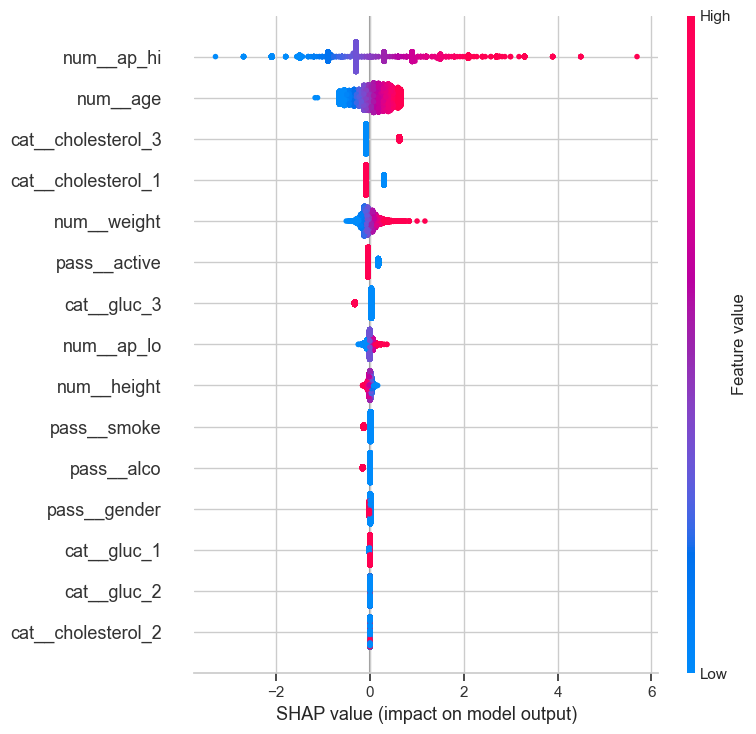

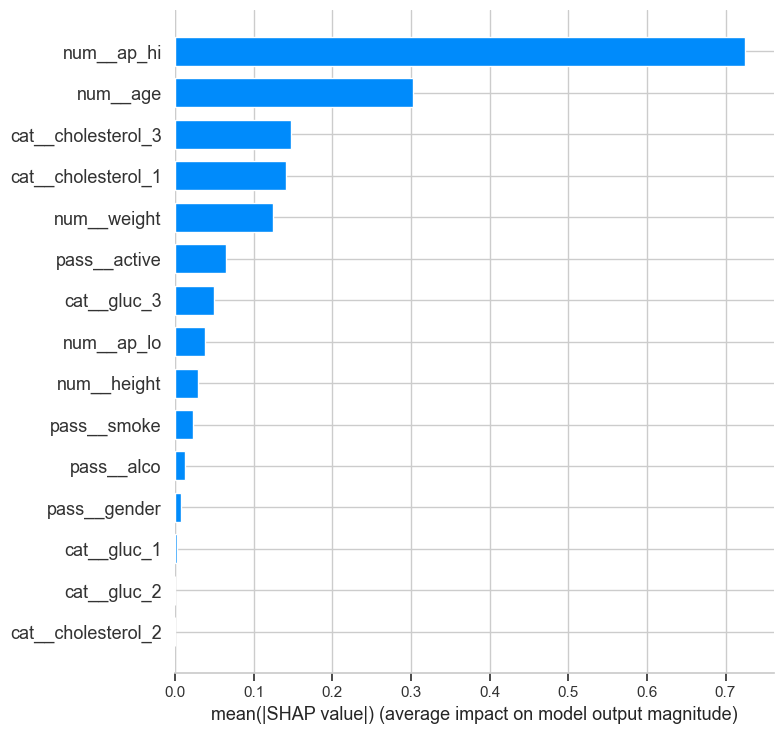

,Feature,Coefficient
3,num__ap_hi,0.949298
7,cat__cholesterol_3,0.711394
0,num__age,0.351669
2,num__weight,0.158431
4,num__ap_lo,0.056755
8,cat__gluc_1,0.012540
6,cat__cholesterol_2,0.000000
9,cat__gluc_2,0.000000
11,pass__gender,-0.017789
1,num__height,-0.037055


,mean_abs_shap
num__ap_hi,0.725378
num__age,0.303142
cat__cholesterol_3,0.147057
cat__cholesterol_1,0.141052
num__weight,0.124683
pass__active,0.065039
cat__gluc_3,0.049562
num__ap_lo,0.038633
num__height,0.029341
pass__smoke,0.022829


In [49]:
preprocessor_lr = models['logistic_regression'].named_steps['pre']
model_lr = models['logistic_regression'].named_steps['model']

X_train_ = preprocessor_lr.transform(X_train)
X_test_ = preprocessor_lr.transform(X_test)
feature_names_lr = preprocessor_lr.get_feature_names_out()

explainer_lr = shap.LinearExplainer(model_lr, X_train_, feature_perturbation="interventional")
shap_values_lr = explainer_lr.shap_values(X_test_)

display(f"Shap Summary Plot for logistic regression")
shap.summary_plot(shap_values_lr, X_test_, feature_names=feature_names_lr)
shap.summary_plot(shap_values_lr, X_test_, feature_names=feature_names_lr, plot_type="bar")
            
coefficients_df = pd.DataFrame({'Feature': feature_names_lr, 'Coefficient': model_lr.coef_[0]})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)
display(coefficients_df)
            
display(get_shap_summary_df(shap_values_lr, feature_names_lr))

XGBoost

'Shap Summary Plot for XGBoost'

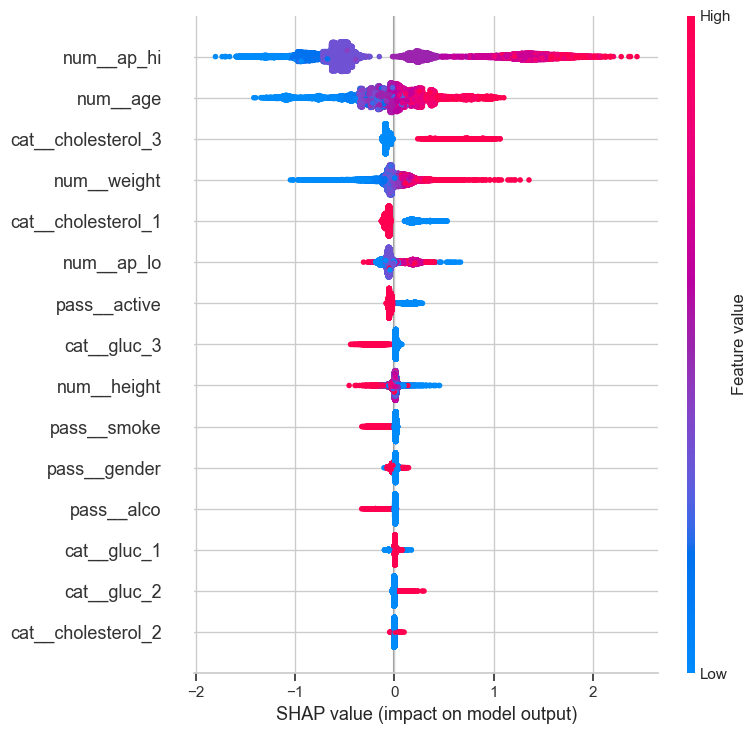

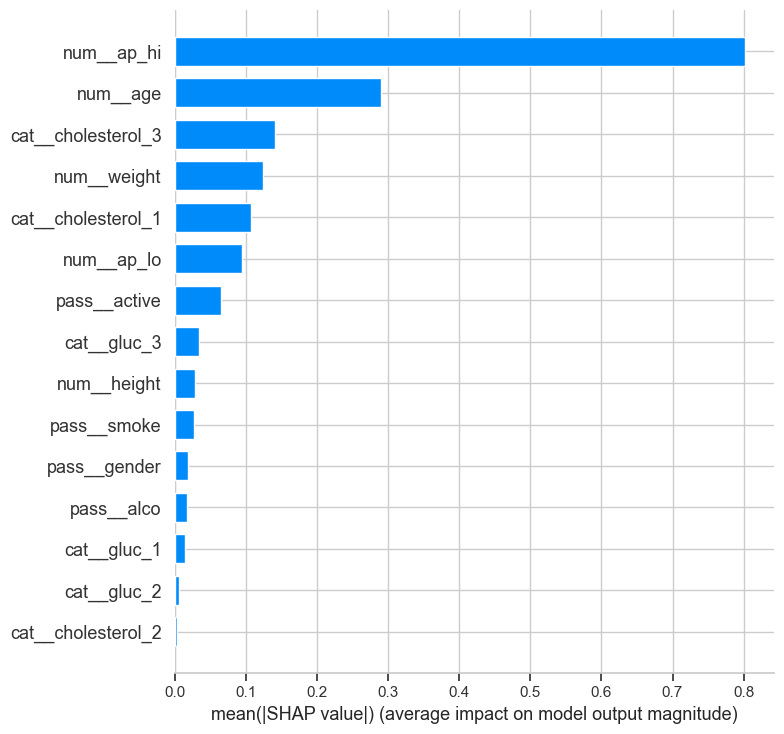

,mean_abs_shap
num__ap_hi,0.802662
num__age,0.289293
cat__cholesterol_3,0.140538
num__weight,0.123521
cat__cholesterol_1,0.106937
num__ap_lo,0.094853
pass__active,0.064887
cat__gluc_3,0.033195
num__height,0.027977
pass__smoke,0.026462


In [50]:
preprocessor_xgb = models['xgboost'].named_steps['pre']
model_xgb = models['xgboost'].named_steps['model']

X_test_ = preprocessor_xgb.transform(X_test)
feature_names_xgb = preprocessor_xgb.get_feature_names_out()

explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_)

display(f"Shap Summary Plot for XGBoost")
shap.summary_plot(shap_values_xgb, X_test_, feature_names=feature_names_xgb)
shap.summary_plot(shap_values_xgb, X_test_, feature_names=feature_names_xgb, plot_type="bar")

display(get_shap_summary_df(shap_values_xgb, feature_names_xgb))
